The quantities we need to compute:

* $P(x)$ - raw popularity of each song.  This should be estimated from a training set.

* $P(e ~|~ u)$ - probability of an edge given a user.  Each user has her own distribution over edges when constructing a transition, as estimated by the statistics of $x_s \odot x_t$ for each $(s, t)$ in the user's history.

* $P(x ~|~ e)$ - probability of a song given an edge.  Condition on membership in a particular edge.

  $$
    P(x ~|~ e) = \frac{P(x) \mathbb{1}[x \in e]}{\sum_{x' \in e} P(x')}
  $$
  
* $P(x ~|~ u, x_p)$ - probability of a song selection given the user and previous song $x_p$.  This can be decomposed in terms of the above as

$$
P(x ~|~ u, x_p) = \sum_e P(x, e ~|~ u, x_p) = \sum_{e} P(x ~|~ e, u) P(e ~|~ u, x_p) = \sum_e P(x ~|~ e) P(e ~|~ u, x_p)
$$

$$
P(e ~|~ u, x_p) = \frac{P(e ~|~ u) \mathbb{1}[x_p \in e]}{\sum_f P(f ~|~ u) \mathbb{1}[x_p \in f]}
$$

The questions we want to answer:

* Aesthetic diversity: for each user, what is $H(P(e~|~u, e \neq \text{uniform}))$?  
* Breadth vs depth: what is $H(P(e~|~u))$ vs $\mathbf{E}_{x\in u}[P(x~|~u)]$?

## Technicality details

The song $x$ is used to estimate $P(e|u)$, so we need to be careful about how we explain and interpret this quantity.  One way to think of it is: if we were to redraw a song $x$ given our crude knowledge about the user (edge affinity), how likely are we to get *this* song?  In other words, can a model of the user's general style (edges) and knowledge of the gross statistics of track selection (popularity) accurately inform the selection of the track?

  - If so, then the user is 'broad' in the sense that their preferences appear similar to the crowd
  - If not, then the user is 'deep', in that they're selecting unpopular tracks relative to others

## Should we be bayesian?

Probably we will need priors on the distributions $P(x)$ and $P(e | u)$.

* $P(x) \sim \textbf{Dirichlet}(\alpha_0)$  (assume the distribution over all songs is multinomial)
* $P(e ~|~ u) \sim \textbf{Dirichlet}(\alpha_1)$

To be fully bayesian, we should integrate out the posteriors in all relevant computations, rather than taking point estimates (modes).

In [1]:
import pandas as pd
import scipy
import numpy as np

import progressbar
import seaborn
import matplotlib.pyplot as plt
seaborn.set()
%matplotlib inline

In [58]:
def load_edges(*files, **kwargs):
    
    min_size = kwargs.get('min_size', 100)
    
    frames = [pd.read_pickle(_) for _ in files]
    frames = [frame.drop(frame.columns[frame.count() < min_size], axis=1).to_dense()
              for frame in frames]
    
    H = frames.pop(0)
    
    while len(frames):
        H = H.join(frames.pop(0), how='outer', sort=True)
    
    H.index.name = 'song_id'
    H = H.fillna(value=0.0)
    #H = H.to_sparse()
    return H

In [35]:
def p_edge_given_user(Ht, playlists, alpha=1.0, min_bigrams=5, max_users=None, count_unigrams=False):
    '''Estimate the edge distribution for each user.
    
    Parameters
    ----------
    Ht :  n_edges * n_songs dataframe
    
    playlists : hierarchical dataframe
    
    alpha : scalar or ndarray
        Vector of hyperparameters
        
    '''
    
    
    stats_frame = pd.DataFrame(columns=Ht.index, dtype='float32')
    
    if max_users is None:
        max_users = len(playlists.index.levels[0])
    
    widgets = [progressbar.Percentage(),
               ' ',
               progressbar.Bar(marker=progressbar.RotatingMarker()),
               ' ',
               progressbar.ETA()]
    
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=max_users).start()
    
    for user in playlists.index.levels[0]:
        
        if len(stats_frame) >= max_users:
            break
        
        u_stat = alpha
        n_bigrams = 0
        
        for (mix_id, segment_id), group in playlists.loc[user].groupby(level=[0,1]):
            if count_unigrams:
                u_stat = u_stat + Ht[group['song_id'][0]].to_dense()
                
            for s, t in zip(group['song_id'][:-1], group['song_id'][1:]):
                # Accumulate
                transition = Ht[s] * Ht[t]
                u_stat = u_stat + transition.to_dense()
                n_bigrams += 1
                          
        if n_bigrams < min_bigrams:
            continue
        
        model = scipy.stats.dirichlet(u_stat)
        stats_frame.loc[user] = model.mean()
        
        pbar.update(len(stats_frame.index))
    
    pbar.finish()
    
    return stats_frame

In [4]:
def song_given_edge(song_prob, H_T):
    
    mpe = H_T.dot(song_prob)
    
    return (H_T.divide(mpe['Probability'], axis='index') * song_prob['Probability'])    

In [5]:
def p_song_given_user(playlists, spe_t, edge_given_user, aggregate=scipy.stats.gmean):
    
    song_stats = pd.DataFrame(index=edge_given_user.index, columns=['log probability'])
        
    widgets = [progressbar.Percentage(),
               ' ',
               progressbar.Bar(marker=progressbar.RotatingMarker()),
               ' ',
               progressbar.ETA()]
    
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(song_stats.index)).start()
    
    for i, u in enumerate(edge_given_user.index):
        # Get the songs for this user
        user_songs = playlists.loc[u]['song_id']
        u_vec = edge_given_user.loc[u]
        
        song_given_user = u_vec.dot(spe_t[user_songs]).to_frame()
        
        song_stats.loc[u] = song_given_user.apply(aggregate)[0]
        pbar.update(i)
        
    pbar.finish()
    
    return song_stats.applymap(np.log)
        

In [6]:
def h_song_given_user(spe_t, edge_given_user):
    
    song_stats = pd.DataFrame(index=edge_given_user.index, columns=['song entropy'])
        
    widgets = [progressbar.Percentage(),
               ' ',
               progressbar.Bar(marker=progressbar.RotatingMarker()),
               ' ',
               progressbar.ETA()]
    
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(song_stats.index)).start()
    
    for i, u in enumerate(edge_given_user.index):
        # Get the songs for this user
        u_vec = edge_given_user.loc[u]
        
        song_stats.loc[u] = scipy.stats.entropy(u_vec.dot(spe_t).values)
        
        pbar.update(i)
        
    pbar.finish()
    
    return song_stats
        

In [36]:
def p_song_given_user_prev(playlists, spe_t, Ht, edge_given_user, aggregate=scipy.stats.gmean):
    
    song_stats = pd.DataFrame(index=edge_given_user.index, columns=['log probability'])
    
    widgets = [progressbar.Percentage(),
               ' ',
               progressbar.Bar(marker=progressbar.RotatingMarker()),
               ' ',
               progressbar.ETA()]
    
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(song_stats.index)).start()
    
    for i, u in enumerate(edge_given_user.index):
        # Get the songs for this user
        user_songs = playlists.loc[u]['song_id']
        u_vec = edge_given_user.loc[u]
        
        song_given_user = []
        
        for (mix_id, segment_id), group in playlists.loc[u].groupby(level=[0,1]):
            for s, t in zip(group['song_id'][:-1], group['song_id'][1:]):
                # Accumulate
                u_vec = (Ht[s] * edge_given_user.loc[u]).to_dense()
                song_given_user.append(u_vec.T.dot(spe_t[t].to_dense()) / u_vec.sum())
                #song_given_user.append(u_vec.T.dot(spe_t[t]) / u_vec.sum())
        
        song_stats.loc[u] = pd.DataFrame(song_given_user).apply(aggregate)[0]
        
        pbar.update(i)
        
    pbar.finish()
    
    return song_stats.applymap(np.log)
        

In [8]:
def song_counts(playlists, songs):
    raw_counts = pd.Series(data=0.0, index=songs) + playlists.groupby('song_id')['timestamp'].aggregate('count')
    raw_counts = raw_counts.fillna(0).to_frame(name='Counts')
    raw_counts.index.name = 'song_id'
    
    return raw_counts

In [9]:
def p_song(playlists, songs, alpha=1.0):
    
    K = len(songs)
    
    raw_counts = song_counts(playlists, songs)
    
    model = scipy.stats.dirichlet(alpha=raw_counts['Counts'] + alpha)
    
    probs = pd.DataFrame(index=raw_counts.index,
                         columns=['Probability'],
                         data=model.mean())
    
    return probs

In [10]:
def get_song_names():
    
    song_names = pd.read_json('/home/bmcfee/git/playlist_recommender/data/valid_songs.json', orient='index')
    song_names.index.name = 'song_id'
    return song_names

In [11]:
def get_user(playlists, user):
    
    return playlists.loc[[user]].join(song_names, on='song_id')

In [12]:
song_names = get_song_names()

In [13]:
fold = 0

In [14]:
playlists_train = pd.read_pickle('/home/bmcfee/git/playlist_recommender/data/folds/{:d}_train.pickle'.format(fold))
playlists_test = pd.read_pickle('/home/bmcfee/git/playlist_recommender/data/folds/{:d}_test.pickle'.format(fold))

In [59]:
H_frame = load_edges('/home/bmcfee/git/playlist_recommender/data/edges/uniform.pickle',
                     '/home/bmcfee/git/playlist_recommender/data/edges/tags.pickle',
                     '/home/bmcfee/git/playlist_recommender/data/edges/era_decade.pickle',
                     '/home/bmcfee/git/playlist_recommender/data/edges/era_year.pickle',
                     '/home/bmcfee/git/playlist_recommender/data/edges/audio.pickle',
                     min_size=200)

In [61]:
H_frame_T = pd.DataFrame(index=H_frame.columns,
                         columns=H_frame.index,
                         data=H_frame.values.T)

In [63]:
song_prob = p_song(playlists_train, H_frame.index)

In [64]:
spe_t = song_given_edge(song_prob, H_frame_T)

In [156]:
scipy.stats.entropy(song_prob)

array([ 10.73639458])

In [65]:
song_prob.describe()

,Probability
count,114464.000000
mean,0.000009
std,0.000022
min,0.000001
25%,0.000003
50%,0.000003
75%,0.000007
max,0.000934


In [66]:
song_names.loc[song_prob['Probability'].argmax()]

artist                  Pixies
title        Where Is My Mind?
track_id    TRNNGMK128F423F034
Name: SOBBKGF12A8C1311EE, dtype: object

In [168]:
p_egu = p_edge_given_user(H_frame_T, playlists_test, count_unigrams=True, min_bigrams=10, alpha=0.5)

In [169]:
edge_diversity = p_egu.drop('[UNIFORM]', axis=1).apply(scipy.stats.entropy, axis=1).to_frame(name='Entropy')

In [170]:
track_diversity = h_song_given_user(spe_t, p_egu)

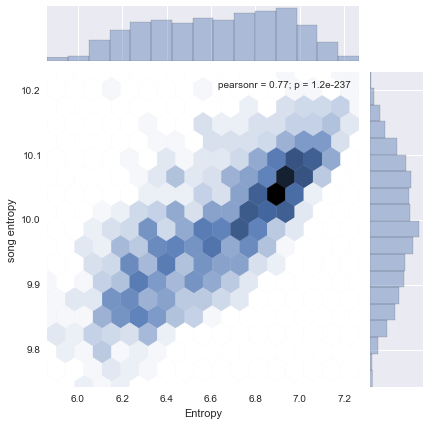

In [171]:
seaborn.jointplot(edge_diversity['Entropy'],
                  track_diversity['song entropy'],
                  kind='hex')

In [172]:
P = p_song_given_user(playlists_test, spe_t, p_egu)

100% |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| Time: 0:00:09


In [173]:
P2 = p_song_given_user_prev(playlists_test, spe_t, H_frame_T, p_egu)

100% |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| Time: 0:02:01


Using localized song selection probability


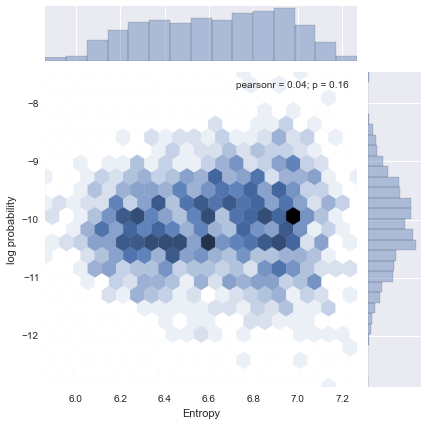

In [174]:
print 'Using localized song selection probability'
seaborn.jointplot(edge_diversity['Entropy'],
                  P2.loc[p_egu.index]['log probability'],
                  kind='hex')
pass

H(Song | user) vs log P(Song = x_t | user)


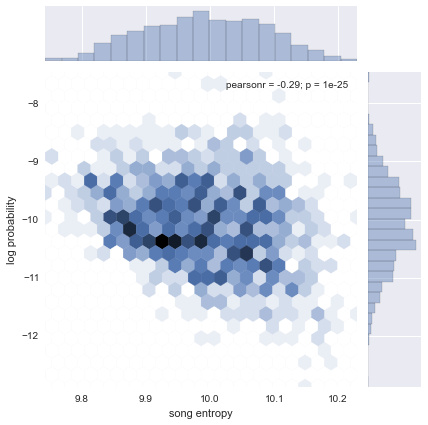

In [175]:
print 'H(Song | user) vs log P(Song = x_t | user)'
seaborn.jointplot(track_diversity['song entropy'], 
                  P2.loc[p_egu.index]['log probability'],
                  kind='hex')
pass

Using global song selection probability


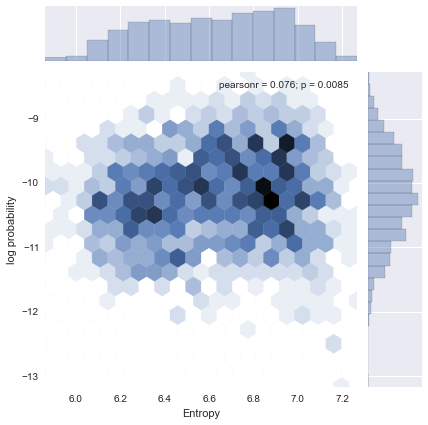

In [176]:
print 'Using global song selection probability'
seaborn.jointplot(edge_diversity['Entropy'],
                  P.loc[p_egu.index]['log probability'],
                  kind='hex')
pass

---
## User investigation

In [184]:
num_songs = playlists_test.groupby(level=[0,1,2])[['song_id']].count()

In [185]:
num_segments = num_songs.groupby(level=[0,1]).count()

In [186]:
user_bigram_count = (num_songs.groupby(level=[0,1]).sum() - num_segments).groupby(level=0).sum()
user_bigram_count.columns = ['bigrams']

In [187]:
ent_vs_big = edge_diversity.join(user_bigram_count).dropna()

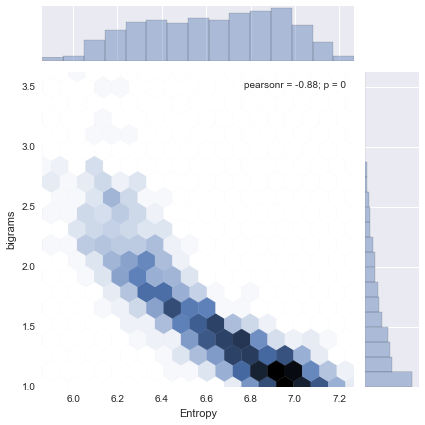

In [188]:
seaborn.jointplot(ent_vs_big['Entropy'],
                  np.log10(ent_vs_big['bigrams']),
                  kind='hex')

In [190]:
user_descriptions = P2.join(edge_diversity)
user_descriptions.describe()

,log probability,Entropy
count,1213.000000,1213.000000
mean,-10.088701,6.624242
std,0.754587,0.306716
min,-12.876879,5.861768
25%,-10.568910,6.366660
50%,-10.085408,6.641848
75%,-9.590327,6.882540
max,-7.455818,7.267231


In [191]:
import cPickle as pickle

In [192]:
with open('../../data/playlist_analysis_data_alpha0.5.pickle', mode='w') as fdesc:
    pickle.dump(dict(p_egu=p_egu,
                     user_descriptions=user_descriptions,
                     playlists_test=playlists_test),
                fdesc, protocol=-1)

In [193]:
import IPython.display

In [194]:
ux = user_descriptions.Entropy.copy()
ux.sort()

In [195]:
lowest_entropy_users = ux.head(10)
highest_entropy_users = ux.tail(10)[::-1]
median_entropy_users = ux._iloc[len(ux)//2 - 5 : len(ux)//2 + 5]

In [196]:
print 'Broadest users'
for user in highest_entropy_users.index:
    print highest_entropy_users.loc[[user]]
    IPython.display.display(get_user(playlists_test, user))
    print

Broadest users
Andruce    7.267231
Name: Entropy, dtype: float64


category             song_id  \
user    mix_id segment_id segment_position                                    
Andruce 6920   0          0                 Mixed Genre  SODMAYX12A6D4F7AC4   
               1          0                 Mixed Genre  SOSJVCO12A8C136E93   
                          1                 Mixed Genre  SOERSBA12A6D4F9823   
               2          0                 Mixed Genre  SOQWSCJ12A8AE46F1C   
                          1                 Mixed Genre  SOANAXD12A8C131EE5   
                          2                 Mixed Genre  SOWTICW12A6D4FB01C   
                          3                 Mixed Genre  SORKLFE12A8C13714A   
               3          0                 Mixed Genre  SOGWZLB12AB017D019   
                          1                 Mixed Genre  SOIJNRR12A8C1398DA   
               4          0                 Mixed Genre  SOIIJMZ12AB018D1C2   
                          1                 Mixed Genre  SOPARAM12A6D4F80AD   
                          2                 Mixed Genre  SOBBSGU12A6D4FB8E0   
                          3                 Mixed Genre  SOFLPNB12A6701CFAE   
                          4                 Mixed Genre  SOLHPPH12A8C135426   
               5          0                 Mixed Genre  SOORSAZ12A8C13F5C5   
                          1                 Mixed Genre  SOXVSTE12AB017C6A8   
                          2                 Mixed Genre  SOXLBRB12AF729DD4F   
               6          0                 Mixed Genre  SOYQGNF12A6310D857   

                                               timestamp  \
user    mix_id segment_id segment_position                 
Andruce 6920   0          0                 970355640000   
               1          0                 970355640000   
                          1                 970355640000   
               2          0                 970355640000   
                          1                 970355640000   
                          2                 970355640000   
                          3                 970355640000   
               3          0                 970355640000   
                          1                 970355640000   
               4          0                 970355640000   
                          1                 970355640000   
                          2                 970355640000   
                          3                 970355640000   
                          4                 970355640000   
               5          0                 970355640000   
                          1                 970355640000   
                          2                 970355640000   
               6          0                 970355640000   

                                                                       artist  \
user    mix_id segment_id segment_position                                      
Andruce 6920   0          0                                      Beastie Boys   
               1          0                                       Nerf Herder   
                          1                                     The Wannadies   
               2          0                                       The Prodigy   
                          1                 Sly & The Family Stone;Devin Lima   
                          2                                            Weezer   
                          3                                   Third Eye Blind   
               3          0                                   Jungle Brothers   
                          1                                       Get Up Kids   
               4          0                                  The Promise Ring   
                          1                                 Edison Lighthouse   
                          2                                        The Queers   
                          3                                         The Roots   
                          4                       


Liz1234567    7.265827
Name: Entropy, dtype: float64


category             song_id  \
user       mix_id segment_id segment_position                                  
Liz1234567 1036   0          0                 Road Trip  SODCJDX12A6310D8E0   
                             1                 Road Trip  SOCZEXG12AB018DBBD   
                             2                 Road Trip  SOROLJV12A8C143FED   
                             3                 Road Trip  SOUQZOX12AF72A6335   
                  1          0                 Road Trip  SOIRTDQ12A6D4F768D   
                             1                 Road Trip  SOLBPNT12A8C13DB30   
                             2                 Road Trip  SOZDIOV12A6701D7E9   
                             3                 Road Trip  SOQJGEQ12A6D4F72D8   
                  2          0                 Road Trip  SOKGBBT12A6701F64C   
                             1                 Road Trip  SOFQUCO12AF72AB128   
                             2                 Road Trip  SOYGMPF12A67ADE5EF   
                             3                 Road Trip  SOIUBTI12A8C13C36D   
                             4                 Road Trip  SOOJLSM12AB0180267   
                             5                 Road Trip  SOFSNFZ12A6701E171   
                             6                 Road Trip  SOXHWFJ12B0B809CBF   

                                                  timestamp  \
user       mix_id segment_id segment_position                 
Liz1234567 1036   0          0                 913766400000   
                             1                 913766400000   
                             2                 913766400000   
                             3                 913766400000   
                  1          0                 913766400000   
                             1                 913766400000   
                             2                 913766400000   
                             3                 913766400000   
                  2          0                 913766400000   
                             1                 913766400000   
                             2                 913766400000   
                             3                 913766400000   
                             4                 913766400000   
                             5                 913766400000   
                             6                 913766400000   

                                                              artist  \
user       mix_id segment_id segment_position                          
Liz1234567 1036   0          0                        Ben Folds Five   
                             1                             Tuscadero   
                             2                       Porno For Pyros   
                             3                            Eurythmics   
                  1          0                             Liz Phair   
                             1                            Chaka Khan   
                             2                       The Temptations   
                             3                          The Breeders   
                  2          0                 The Mamas & The Papas   
                             1                               Warrant   
                             2                            The Smiths   
                             3                        Throwing Muses   
                             4                      Jane's Addiction   
                             5                            Pretenders   
                             6                               Cracker   

                                                                       title  \
user       mix_id segment_id segment_position                                  
Liz1234567 1036   0          0                               Jackson Cannery   
                             1                     Freak Magnet (LP Version)   
                             2                          Meija ( LP Ver


Charles Henry Hammons    7.25837
Name: Entropy, dtype: float64


category  \
user                  mix_id segment_id segment_position                  
Charles Henry Hammons 12661  0          0                 Single Artist   
                                        1                 Single Artist   
                                        2                 Single Artist   
                                        3                 Single Artist   
                                        4                 Single Artist   
                                        5                 Single Artist   
                                        6                 Single Artist   
                                        7                 Single Artist   
                                        8                 Single Artist   
                                        9                 Single Artist   
                                        10                Single Artist   

                                                                     song_id  \
user                  mix_id segment_id segment_position                       
Charles Henry Hammons 12661  0          0                 SONXGNZ12B0B809072   
                                        1                 SOCWTWB12A58A7E4A4   
                                        2                 SORVWZW12B0B809065   
                                        3                 SOBRFBV12A8C142C8B   
                                        4                 SOVOHSX12AF72A1784   
                                        5                 SOEGBGW12A8C142CA0   
                                        6                 SOZKJDM12A8C143448   
                                        7                 SONYCSG12A8C143420   
                                        8                 SOUWEOU12A8C14345C   
                                        9                 SOIZSCO12A8C143498   
                                        10                SOMIEDP12A6D4FD1C8   

                                                             timestamp artist  \
user                  mix_id segment_id segment_position                        
Charles Henry Hammons 12661  0          0                 992655960000   Ween   
                                        1                 992655960000   Ween   
                                        2                 992655960000   Ween   
                                        3                 992655960000   Ween   
                                        4                 992655960000   Ween   
                                        5                 992655960000   Ween   
                                        6                 992655960000   Ween   
                                        7                 992655960000   Ween   
                                        8                 992655960000   Ween   
                                        9                 992655960000   Ween   
                                        10                992655960000   Ween   

                                                                                      title  \
user                  mix_id segment_id segment_position                                      
Charles Henry Hammons 12661  0          0                        Back To Basom (LP Version)   
                                        1                     Bananas And Blow (LP Version)   
                                        2                    Even If You Don't (LP Version)   
                                        3                 Exactly Where I'm At (LP Version)   
                                        4                          Falling Out (LP Version)   
                                        5                        Flutes Of Chi (LP Version)   
                                        6                            The Grobe (LP Version)   
                                        7                          Ice Castles (LP Version)   
                                        8 


henry west    7.223275
Name: Entropy, dtype: float64


category  \
user       mix_id segment_id segment_position                
henry west 1772   0          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                             3                 Mixed Genre   
                  1          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                             3                 Mixed Genre   
                  2          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                             3                 Mixed Genre   
                             4                 Mixed Genre   
                  3          0                 Mixed Genre   
                             1                 Mixed Genre   
                  4          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   

                                                          song_id  \
user       mix_id segment_id segment_position                       
henry west 1772   0          0                 SOUHBNB12B0B809347   
                             1                 SOFQLKW12AB0189FD8   
                             2                 SOLNDEY12A67021436   
                             3                 SOQVIPD12A8C14384E   
                  1          0                 SOYHYGV12A8AE479B6   
                             1                 SOSROSV12A6D4F9A72   
                             2                 SOTJDBL12A6D4F75E0   
                             3                 SOJNFQR12A8C13F5E9   
                  2          0                 SOHWZTI12AF72A1947   
                             1                 SOOHDEK12A6D4F828C   
                             2                 SOYCFEN12A6D4F7953   
                             3                 SOGGHRK12A8C13C403   
                             4                 SOYKIOA12A6D4FA549   
                  3          0                 SOZKCCH12A81C20E3B   
                             1                 SOITUAG12AB0180735   
                  4          0                 SOKHSIN12AB0183626   
                             1                 SOELEJG12A8C142FA7   
                             2                 SOGUVCK12A58A7E71D   

                                                  timestamp  \
user       mix_id segment_id segment_position                 
henry west 1772   0          0                 926091600000   
                             1                 926091600000   
                             2                 926091600000   
                             3                 926091600000   
                  1          0                 926091600000   
                             1                 926091600000   
                             2                 926091600000   
                             3                 926091600000   
                  2          0                 926091600000   
                             1                 926091600000   
                             2                 926091600000   
                             3                 926091600000   
                             4                 926091600000   
                  3          0                 926091600000   
                             1                 926091600000   
                  4          0                 926091600000   
                             1                 926091600000   
                             2                 926091600000   

                                                                artist  \
user       mix_id segment_id segment_position                            
henry west 1772   0


ashley1234567890    7.222002
Name: Entropy, dtype: float64


category  \
user             mix_id segment_id segment_position                
ashley1234567890 12754  0          0                 Mixed Genre   
                                   1                 Mixed Genre   
                        2          0                 Mixed Genre   
                                   1                 Mixed Genre   
                                   2                 Mixed Genre   
                        3          0                 Mixed Genre   
                                   1                 Mixed Genre   
                                   2                 Mixed Genre   
                                   3                 Mixed Genre   
                                   4                 Mixed Genre   
                        4          0                 Mixed Genre   
                                   1                 Mixed Genre   
                                   2                 Mixed Genre   
                        5          0                 Mixed Genre   
                                   1                 Mixed Genre   

                                                                song_id  \
user             mix_id segment_id segment_position                       
ashley1234567890 12754  0          0                 SOVCZBU12AB0184C69   
                                   1                 SOJHGZZ12A8AE46FD4   
                        2          0                 SOWWNHU12A8AE467D0   
                                   1                 SOMTDBP12A6D4F8256   
                                   2                 SOGWFYN12A8C14413D   
                        3          0                 SOAKSTJ12AB0187188   
                                   1                 SODKCAI12A8C133A0B   
                                   2                 SOMGSKY12AB0186EDD   
                                   3                 SOIJNUF12B34F1C0B5   
                                   4                 SOESQNH12A58A79AC3   
                        4          0                 SOGLCXA12A8C137B21   
                                   1                 SOGREYE12A67020419   
                                   2                 SOTFJYO12A8C1366C8   
                        5          0                 SODPKYE12AB01803B9   
                                   1                 SOASIDK12A81C207C1   

                                                        timestamp  \
user             mix_id segment_id segment_position                 
ashley1234567890 12754  0          0                 992901300000   
                                   1                 992901300000   
                        2          0                 992901300000   
                                   1                 992901300000   
                                   2                 992901300000   
                        3          0                 992901300000   
                                   1                 992901300000   
                                   2                 992901300000   
                                   3                 992901300000   
                                   4                 992901300000   
                        4          0                 992901300000   
                                   1                 992901300000   
                                   2                 992901300000   
                        5          0                 992901300000   
                                   1                 992901300000   

                                                                       artist  \
user             mix_id segment_id segment_position                             
ashley1234567890 12754  0          0                                 Iggy Pop   
                                   1                           New Bomb Turks   
                        2          0                                Tarnation   
                                   1        


ReverendGirl    7.206077
Name: Entropy, dtype: float64


category  \
user         mix_id segment_id segment_position                  
ReverendGirl 4017   0          0                 Single Artist   
                               1                 Single Artist   
                               2                 Single Artist   
                    1          0                 Single Artist   
                    2          0                 Single Artist   
                               1                 Single Artist   
                               2                 Single Artist   
                    3          0                 Single Artist   
                    4          0                 Single Artist   
                               1                 Single Artist   
                               2                 Single Artist   
                               3                 Single Artist   
                               4                 Single Artist   
                               5                 Single Artist   
                               6                 Single Artist   
                    5          0                 Single Artist   
                               1                 Single Artist   
                               2                 Single Artist   
                               3                 Single Artist   

                                                            song_id  \
user         mix_id segment_id segment_position                       
ReverendGirl 4017   0          0                 SOYOMYH12A8BEEEEBE   
                               1                 SODCNVB12A8C138EEC   
                               2                 SODYGTC12AF72A1CFF   
                    1          0                 SOHJWJX12A8BEEEEDA   
                    2          0                 SOJCVEB12A8BEEEEF0   
                               1                 SOFGKBZ12AB0180748   
                               2                 SOGWWNJ12AB017EC98   
                    3          0                 SOIIRHU12AF72A4D7C   
                    4          0                 SODJYUS12A8C13B8A4   
                               1                 SOWXEOC12A8BEEEF0D   
                               2                 SOPCQQL12A8BEEEEFE   
                               3                 SONBYCU12A8C138F07   
                               4                 SOIPOOC12A8BEEEF0B   
                               5                 SOORQHS12A8BEEEEFA   
                               6                 SOOZVBF12A8BEEEF20   
                    5          0                 SOHGFDO12AF72A41CB   
                               1                 SOCNIII12A8BEEEF04   
                               2                 SOURYPC12A8BEEEEEF   
                               3                 SOFPMLY12AF72A413F   

                                                    timestamp          artist  \
user         mix_id segment_id segment_position                                 
ReverendGirl 4017   0          0                 953857140000  The Verve Pipe   
                               1                 953857140000  The Verve Pipe   
                               2                 953857140000  The Verve Pipe   
                    1          0                 953857140000  The Verve Pipe   
                    2          0                 953857140000  The Verve Pipe   
                               1                 953857140000  The Verve Pipe   
                               2                 953857140000  The Verve Pipe   
                    3          0                 953857140000  The Verve Pipe   
                    4          0                 953857140000  The Verve Pipe   
                               1                 953857140000  The Verve Pipe   
                               2                 953857140000  The Verve Pipe   
                               3                 953857140000  The Verve Pipe   
                               4         


GlowKitten    7.205815
Name: Entropy, dtype: float64


category  \
user       mix_id segment_id segment_position                
GlowKitten 9769   0          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                             3                 Mixed Genre   
                  1          0                 Mixed Genre   
                             1                 Mixed Genre   
                  2          0                 Mixed Genre   
                  3          0                 Mixed Genre   
                             1                 Mixed Genre   
                  4          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                             3                 Mixed Genre   
                  5          0                 Mixed Genre   
                  6          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   

                                                          song_id  \
user       mix_id segment_id segment_position                       
GlowKitten 9769   0          0                 SONDBJB12A8C13125F   
                             1                 SOVBORF12AC3DF57B6   
                             2                 SOPAGDK12AB018AC80   
                             3                 SOEIIIL12A8AE46A89   
                  1          0                 SOHPXOY12AB017CFD9   
                             1                 SODBICI12AB017E5DB   
                  2          0                 SOSEBAI12A8C132FEC   
                  3          0                 SOBLBDZ12A6D4F7416   
                             1                 SOQCJJQ12AB0186CB2   
                  4          0                 SOGBGRX12A8C132A1B   
                             1                 SODTUIZ12A6D4FC358   
                             2                 SORNNFD12A8C1442F1   
                             3                 SOLOFYI12A8C145F8D   
                  5          0                 SOAPQRV12AC468AA3E   
                  6          0                 SOJDTYX12A8C13B4D4   
                             1                 SOUDIAF12873FD5545   
                             2                 SOZKJLI12AB018270F   

                                                  timestamp  \
user       mix_id segment_id segment_position                 
GlowKitten 9769   0          0                 982893000000   
                             1                 982893000000   
                             2                 982893000000   
                             3                 982893000000   
                  1          0                 982893000000   
                             1                 982893000000   
                  2          0                 982893000000   
                  3          0                 982893000000   
                             1                 982893000000   
                  4          0                 982893000000   
                             1                 982893000000   
                             2                 982893000000   
                             3                 982893000000   
                  5          0                 982893000000   
                  6          0                 982893000000   
                             1                 982893000000   
                             2                 982893000000   

                                                                 artist  \
user       mix_id segment_id segment_position                             
GlowKitten 9769   0          0                              Fiona Apple   
                             1                         A Perfect Circle   
                             2                          Sarah


jess1234567    7.199928
Name: Entropy, dtype: float64


category             song_id  \
user        mix_id segment_id segment_position                                
jess1234567 16797  0          0                   Theme  SOQJACW12A6D4FD05E   
                              1                   Theme  SOASYSL12A6310D898   
                   1          0                   Theme  SOHUPRL12AB018B38E   
                              1                   Theme  SOBGTVR12A6BD55C92   
                              2                   Theme  SOHGYNZ12A8C13E052   
                              3                   Theme  SOHTXAW12A8C142E41   
                              4                   Theme  SOGPYOX12A6D4F7EDB   
                   2          0                   Theme  SOOZNGS12AB0185170   
                              1                   Theme  SOFHYIB12AB017D72E   
                              2                   Theme  SOZAKXU12A6D4F6893   
                   3          0                   Theme  SOLUHVU12A8C13A225   
                              1                   Theme  SOIIEUC12A6D4FA2C6   
                              2                   Theme  SOKIAJA12A8C13597E   
                              3                   Theme  SOZZNWH12A8AE481B7   
            21232  0          0                   Theme  SOQTZYK12A58A7E220   
                   1          0                   Theme  SOXBNSI12A58A7D44B   

                                                    timestamp  \
user        mix_id segment_id segment_position                  
jess1234567 16797  0          0                 1004208120000   
                              1                 1004208120000   
                   1          0                 1004208120000   
                              1                 1004208120000   
                              2                 1004208120000   
                              3                 1004208120000   
                              4                 1004208120000   
                   2          0                 1004208120000   
                              1                 1004208120000   
                              2                 1004208120000   
                   3          0                 1004208120000   
                              1                 1004208120000   
                              2                 1004208120000   
                              3                 1004208120000   
            21232  0          0                 1012596900000   
                   1          0                 1012596900000   

                                                                artist  \
user        mix_id segment_id segment_position                           
jess1234567 16797  0          0                            Subway Sect   
                              1                       The Human League   
                   1          0                              The Slits   
                              1                          The Pop Group   
                              2                           Joy Division   
                              3                             Swell Maps   
                              4                               Magazine   
                   2          0                                Flipper   
                              1                          Family Fodder   
                              2                         Liquid_ Liquid   
                   3          0                       Mission Of Burma   
                              1                       Public Image Ltd   
                              2                    Young Marble Giants   
                              3                        Scritti Politti   
            21232  0          0                 The Velvet Underground   
                   1          0                              Brian Eno   

                                                                                            title  \
user        mix_id 


Molochmayhem    7.191994
Name: Entropy, dtype: float64


category             song_id  \
user         mix_id segment_id segment_position                                 
Molochmayhem 16721  0          0                 Rock/Pop  SONZFRQ12AB01822E2   
                    1          0                 Rock/Pop  SOVEWJN12A58A80066   
                               1                 Rock/Pop  SOGPPVA12AB017B1FC   
                               2                 Rock/Pop  SOYKKUJ12AB018D16A   
                               3                 Rock/Pop  SOIAUJJ12A58A7FD28   
                               4                 Rock/Pop  SONEVGB12A8AE4672D   
                               5                 Rock/Pop  SOJTQXQ12A81C20B3E   
                    2          0                 Rock/Pop  SOOGFCP12A6D4F679F   
                    3          0                 Rock/Pop  SODGXLF12AB0187E9D   
                               1                 Rock/Pop  SOVNJZT12A8AE4505E   
                               2                 Rock/Pop  SOIGFML12AB017F3C7   
                               3                 Rock/Pop  SOWJMGE12A6D4F58B7   
                               4                 Rock/Pop  SOSEACQ12AAF3B45B7   
                               5                 Rock/Pop  SOEFNZC12AB017E11E   
                               6                 Rock/Pop  SORILPN12A8C135087   
                               7                 Rock/Pop  SOTEMVZ12A58A7CF45   

                                                     timestamp  \
user         mix_id segment_id segment_position                  
Molochmayhem 16721  0          0                 1003940640000   
                    1          0                 1003940640000   
                               1                 1003940640000   
                               2                 1003940640000   
                               3                 1003940640000   
                               4                 1003940640000   
                               5                 1003940640000   
                    2          0                 1003940640000   
                    3          0                 1003940640000   
                               1                 1003940640000   
                               2                 1003940640000   
                               3                 1003940640000   
                               4                 1003940640000   
                               5                 1003940640000   
                               6                 1003940640000   
                               7                 1003940640000   

                                                          artist  \
user         mix_id segment_id segment_position                    
Molochmayhem 16721  0          0                    Celtic Frost   
                    1          0                    Metal Church   
                               1                     DESTRUCTION   
                               2                   Destroyer 666   
                               3                         Anthrax   
                               4                           DEATH   
                               5                   Mercyful Fate   
                    2          0                     Iron Maiden   
                    3          0                   Black Sabbath   
                               1                        Megadeth   
                               2                         Kreator   
                               3                       Metallica   
                               4                 Nuclear Assault   
                               5                         bathory   
                               6                          Accept   
                               7                         Emperor   

                                                                             title  \
user         mix_id segment_id segment_position                                      
Molo


Fence Wilson    7.182314
Name: Entropy, dtype: float64


category  \
user         mix_id segment_id segment_position                
Fence Wilson 3040   0          0                 Mixed Genre   
                    1          0                 Mixed Genre   
                               1                 Mixed Genre   
                               2                 Mixed Genre   
                    2          0                 Mixed Genre   
                    3          0                 Mixed Genre   
                               1                 Mixed Genre   
                    4          0                 Mixed Genre   
                               1                 Mixed Genre   
                               2                 Mixed Genre   
                               3                 Mixed Genre   
                               4                 Mixed Genre   
                    5          0                 Mixed Genre   
                               1                 Mixed Genre   
                    6          0                 Mixed Genre   
                               1                 Mixed Genre   
                               2                 Mixed Genre   

                                                            song_id  \
user         mix_id segment_id segment_position                       
Fence Wilson 3040   0          0                 SOZOIKA12A8AE46AF2   
                    1          0                 SOJBIHD12AB018CB08   
                               1                 SOSTCFP12A8C13EE12   
                               2                 SOEEIWU12A8C13F7BB   
                    2          0                 SOAIYFP12A8C139152   
                    3          0                 SOOVZJC12A6D4F8434   
                               1                 SODSPBS12A6D4FA22A   
                    4          0                 SOJFZEE12A6701D301   
                               1                 SOBSEUZ12AC9071B60   
                               2                 SOPDERA12A8C130A44   
                               3                 SOSQVWN12A6D4F5FD7   
                               4                 SOSCBTX12A67020A1A   
                    5          0                 SOBVWMH12A6D4F4F00   
                               1                 SOBJZCN12A6D4F80E2   
                    6          0                 SONCGWZ12A81C214D9   
                               1                 SOSBQVA12A8C13E182   
                               2                 SODVFEA12AB018A783   

                                                    timestamp  \
user         mix_id segment_id segment_position                 
Fence Wilson 3040   0          0                 944610540000   
                    1          0                 944610540000   
                               1                 944610540000   
                               2                 944610540000   
                    2          0                 944610540000   
                    3          0                 944610540000   
                               1                 944610540000   
                    4          0                 944610540000   
                               1                 944610540000   
                               2                 944610540000   
                               3                 944610540000   
                               4                 944610540000   
                    5          0                 944610540000   
                               1                 944610540000   
                    6          0                 944610540000   
                               1                 944610540000   
                               2                 944610540000   

                                                               artist  \
user         mix_id segment_id segment_position                         
Fence Wilson 3040   0          0                 They Might Be Giants   
                    1         

In [197]:
print 'Narrowest users'
for user in lowest_entropy_users.index:
    print lowest_entropy_users.loc[[user]]
    IPython.display.display(get_user(playlists_test, user))
    print

Narrowest users
Bang1    5.861768
Name: Entropy, dtype: float64


category             song_id  \
user  mix_id segment_id segment_position                                    
Bang1 8085   0          0                 Mixed Genre  SOMVOKG12A58A7AC64   
                        1                 Mixed Genre  SOPTLLY12A58A7B21B   
             1          0                 Mixed Genre  SOHQELP12A8C13645A   
                        1                 Mixed Genre  SOLZRQN12A8C138E34   
                        2                 Mixed Genre  SOXOEUA12A8C140C38   
                        3                 Mixed Genre  SOSBQSS12AB0189C58   
             2          0                 Mixed Genre  SOWOZJP12AAA15D8B3   
      8146   0          0                 Mixed Genre  SOFCYDT12AB017E767   
                        1                 Mixed Genre  SOQDJWJ12AF72A7AAF   
             1          0                 Mixed Genre  SOMOCJR12A6702031A   
             2          0                 Mixed Genre  SOIKOZD12A8C13D79A   
                        1                 Mixed Genre  SOMTXSB12AF72ACC38   
             4          0                 Mixed Genre  SOQJZWZ12A6D4FC00E   
             5          0                 Mixed Genre  SOWOZJP12AAA15D8B3   
      8394   0          0                 Mixed Genre  SOGQUIN12A6701F2C4   
             2          0                 Mixed Genre  SOPTLLY12A58A7B21B   
             3          0                 Mixed Genre  SOHQELP12A8C13645A   
                        1                 Mixed Genre  SOZWOZC12A8C136CDF   
             4          0                 Mixed Genre  SOXOEUA12A8C140C38   
                        1                 Mixed Genre  SOSBQSS12AB0189C58   
                        2                 Mixed Genre  SOWOZJP12AAA15D8B3   
      8596   0          0                 Mixed Genre  SOZWOZC12A8C136CDF   
                        1                 Mixed Genre  SOLZRQN12A8C138E34   
                        2                 Mixed Genre  SOHQELP12A8C13645A   
                        3                 Mixed Genre  SOUFXKR12AB0184AFC   
                        4                 Mixed Genre  SOPTLLY12A58A7B21B   
             1          0                 Mixed Genre  SOMVOKG12A58A7AC64   
             4          0                 Mixed Genre  SOWOZJP12AAA15D8B3   
             5          0                 Mixed Genre  SOSBQSS12AB0189C58   
                        1                 Mixed Genre  SOTAZLZ12A8C138E2F   
...                                               ...                 ...   
      13121  0          2                    Rock/Pop  SOCKFSS12A8C132896   
             1          0                    Rock/Pop  SOUDCZB12A8C139033   
             2          0                    Rock/Pop  SOVRXWW12A6D4F74D3   
                        1                    Rock/Pop  SOHQELP12A8C13645A   
                        2                    Rock/Pop  SOUFXKR12AB0184AFC   
             3          0                    Rock/Pop  SOPTLLY12A58A7B21B   
      13122  0          0                    Rock/Pop  SOPRMWR12A8C139047   
                        1                    Rock/Pop  SOCLTIO12AF72A0958   
                        2                    Rock/Pop  SOCKFSS12A8C132896   
             1          0                    Rock/Pop  SOUDCZB12A8C139033   
             2          0                    Rock/Pop  SOVRXWW12A6D4F74D3   
                        1                    Rock/Pop  SOHQELP12A8C13645A   
                        2                    Rock/Pop  SOUFXKR12AB0184AFC   
             3          0                    Rock/Pop  SOPTLLY12A58A7B21B   
      13123  0          0                    Rock/Pop  SOPRMWR12A8C139047   
                        1                    Rock/Pop  SOCLTIO12AF72A0958   
                        2                    Rock/Pop  SOCKFSS12A8C132896   
             1          0                    Rock/Pop  SOUDCZB12A8C139033   
             2          0                    Rock/Pop  SOVRXWW12A6D4F74D3   
                        1                


Jarrett1    5.863029
Name: Entropy, dtype: float64


category             song_id  \
user     mix_id segment_id segment_position                                   
Jarrett1 5476   0          0                 Indie Rock  SORDDGI12AB017EEF0   
                           1                 Indie Rock  SOPWBHC12AF72A7B35   
                1          0                 Indie Rock  SOEXHUD12A6D4F72D5   
                2          0                 Indie Rock  SOWRLJR12AB01829E4   
                           1                 Indie Rock  SOJSZFY12AB018D1A0   
                           2                 Indie Rock  SOSYDQC12A8C13A68F   
                3          0                 Indie Rock  SOOQVER12A8C13202D   
                4          0                 Indie Rock  SOBVWRF12A6D4F6184   
                           1                 Indie Rock  SOYCWGF12A58A763E8   
                           2                 Indie Rock  SOLYJVL12A58A7D953   
         5513   0          0                 Indie Rock  SORAVNX12A6310F258   
                1          0                 Indie Rock  SODYWBD12A8C139845   
                4          0                 Indie Rock  SOLYJVL12A58A7D953   
                           1                 Indie Rock  SOJPFKE12A6310EF0D   
                           2                 Indie Rock  SOOZVMW12AF72A86DD   
                           3                 Indie Rock  SOZSSXJ12A6D4F8003   
                           4                 Indie Rock  SOKWSAD12A6310EA6A   
                5          0                 Indie Rock  SOEMNRK12A6D4FCA8E   
                6          0                 Indie Rock  SODWWES12AB0181987   
                           1                 Indie Rock  SOYINFW12A679D8AE6   
                           2                 Indie Rock  SOFLDKP12A6310D7A9   
         5569   0          0                 Indie Rock  SOFAIRS12A6D4FA033   
                           1                 Indie Rock  SOJPFKE12A6310EF0D   
                2          0                 Indie Rock  SORUWMN12A6310F95F   
                           1                 Indie Rock  SOIPKYB12A6D4F566C   
                3          0                 Indie Rock  SOHUIPP12AB017F623   
                4          0                 Indie Rock  SOSZTPW12A8C13C113   
                5          0                 Indie Rock  SOGOISE12A6D4FCA75   
                           1                 Indie Rock  SOIJNRR12A8C1398DA   
                           2                 Indie Rock  SOGAKVC12A8C13329C   
...                                                 ...                 ...   
         22432  1          1                 Indie Rock  SOUOWCQ12A6D4F7658   
                2          0                 Indie Rock  SOGDBSU12A6D4F85B0   
                           1                 Indie Rock  SODLENQ12AF72A3DA9   
                3          0                 Indie Rock  SOINSZQ12A6310F244   
                           1                 Indie Rock  SOPTYAU12A58A80362   
                4          0                 Indie Rock  SOZPRHI12A6D4F917B   
                           1                 Indie Rock  SOKBGHT12A6310DF55   
                5          0                 Indie Rock  SOUNXOC12A6D4FB438   
                           1                 Indie Rock  SOTWSXC12A58A7AC33   
         23400  0          0                 Indie Rock  SOEMNRK12A6D4FCA8E   
                1          0                 Indie Rock  SOYOHAO12A670214EC   
                2          0                 Indie Rock  SONFBPV12A8C13D4AD   
                3          0                 Indie Rock  SOJQXTS12A58A7D064   
                           1                 Indie Rock  SONTZLS12A6D4F7D66   
                           2                 Indie Rock  SOSZOGX12A6D4F85AC   
                           3                 Indie Rock  SOVISQY12AB017DC29   
                           4                 Indie Rock  SOYZJML12A8AE473B1   
                4          0                 Indie Rock  SOBITAC12AB0187103   
         23401  0 


Jenn1234    5.865662
Name: Entropy, dtype: float64


category  \
user     mix_id segment_id segment_position                  
Jenn1234 9454   0          0                   Mixed Genre   
                2          0                   Mixed Genre   
                           1                   Mixed Genre   
         9491   0          0                   Mixed Genre   
                           1                   Mixed Genre   
                1          0                   Mixed Genre   
                           1                   Mixed Genre   
                           2                   Mixed Genre   
                           3                   Mixed Genre   
                           4                   Mixed Genre   
                2          0                   Mixed Genre   
                3          0                   Mixed Genre   
                4          0                   Mixed Genre   
         10732  0          0                   Mixed Genre   
                1          0                   Mixed Genre   
                           1                   Mixed Genre   
                2          0                   Mixed Genre   
                           1                   Mixed Genre   
                3          0                   Mixed Genre   
                           1                   Mixed Genre   
                           2                   Mixed Genre   
         10733  0          0                   Mixed Genre   
                1          0                   Mixed Genre   
                           1                   Mixed Genre   
                           2                   Mixed Genre   
                           3                   Mixed Genre   
                           4                   Mixed Genre   
                           5                   Mixed Genre   
                           6                   Mixed Genre   
                2          0                   Mixed Genre   
...                                                    ...   
         60870  3          1                   Mixed Genre   
                           2                   Mixed Genre   
         61375  0          0                   Mixed Genre   
                           1                   Mixed Genre   
                1          0                   Mixed Genre   
                2          0                   Mixed Genre   
                           1                   Mixed Genre   
                4          0                   Mixed Genre   
                           1                   Mixed Genre   
                           2                   Mixed Genre   
                5          0                   Mixed Genre   
                           1                   Mixed Genre   
         61877  0          0                 Single Artist   
                           1                 Single Artist   
                           2                 Single Artist   
                           3                 Single Artist   
                1          0                 Single Artist   
                           1                 Single Artist   
                           2                 Single Artist   
                2          0                 Single Artist   
                3          0                 Single Artist   
                           1                 Single Artist   
         63842  0          0                   Mixed Genre   
                           1                   Mixed Genre   
                2          0                   Mixed Genre   
                3          0                   Mixed Genre   
                           1                   Mixed Genre   
                4          0                   Mixed Genre   
                5          0                   Mixed Genre   
                           1                   Mixed Genre   

                                                        song_id  \
user     mix_id segment_id segment_position                       
Jenn1234 


Candra    5.871006
Name: Entropy, dtype: float64


category  \
user   mix_id segment_id segment_position                     
Candra 644    0          0                 Electronic Music   
                         1                 Electronic Music   
                         2                 Electronic Music   
              1          0                 Electronic Music   
                         1                 Electronic Music   
              2          0                 Electronic Music   
              3          0                 Electronic Music   
              4          0                 Electronic Music   
                         1                 Electronic Music   
                         2                 Electronic Music   
                         3                 Electronic Music   
       705    0          0                 Electronic Music   
                         1                 Electronic Music   
              1          0                 Electronic Music   
                         1                 Electronic Music   
                         2                 Electronic Music   
       713    0          0                 Electronic Music   
              1          0                 Electronic Music   
              2          0                 Electronic Music   
                         1                 Electronic Music   
              3          0                 Electronic Music   
       909    0          0                    Single Artist   
                         1                    Single Artist   
       913    0          0                 Electronic Music   
              1          0                 Electronic Music   
              2          0                 Electronic Music   
                         1                 Electronic Music   
              3          0                 Electronic Music   
                         1                 Electronic Music   
              4          0                 Electronic Music   
...                                                     ...   
       124130 3          0                      Mixed Genre   
              4          0                      Mixed Genre   
                         1                      Mixed Genre   
       124372 0          0                      Mixed Genre   
                         1                      Mixed Genre   
                         2                      Mixed Genre   
              1          0                      Mixed Genre   
                         1                      Mixed Genre   
                         2                      Mixed Genre   
              3          0                      Mixed Genre   
                         1                      Mixed Genre   
                         2                      Mixed Genre   
                         3                      Mixed Genre   
              4          0                      Mixed Genre   
       124522 0          0                      Mixed Genre   
                         1                      Mixed Genre   
              1          0                      Mixed Genre   
                         1                      Mixed Genre   
                         2                      Mixed Genre   
              2          0                      Mixed Genre   
       126459 0          0                      Mixed Genre   
                         1                      Mixed Genre   
                         2                      Mixed Genre   
                         3                      Mixed Genre   
              1          0                      Mixed Genre   
              2          0                      Mixed Genre   
                         1                      Mixed Genre   
              3          0                      Mixed Genre   
                         1                      Mixed Genre   
                         2                      Mixed Genre   

                                                      song_id      timestamp  \
u


Erin H.    5.892091
Name: Entropy, dtype: float64


category             song_id  \
user    mix_id segment_id segment_position                                      
Erin H. 9066   0          0                         Theme  SOXVMHO12A8C1408F8   
               1          0                         Theme  SOLEVBU12AB0184ECA   
                          1                         Theme  SOQMIVG12A679D7E28   
                          2                         Theme  SOLIZIM12A6D4F81BF   
                          3                         Theme  SOPPWHZ12A6D4FA416   
               2          0                         Theme  SOUUSSG12A58A77832   
                          1                         Theme  SOUKOON12AB01824D6   
                          2                         Theme  SODNQHW12A8AE47F91   
                          3                         Theme  SOBNTMC12A6D4FA422   
                          4                         Theme  SOHXRVD12A8C131266   
               3          0                         Theme  SOGKQYK12AB018081D   
        9252   0          0                   Mixed Genre  SOZXSYC12A8C132B85   
                          1                   Mixed Genre  SOGKJDV12AB017FCF3   
               1          0                   Mixed Genre  SOUBUFT12A6D4F761D   
                          1                   Mixed Genre  SOSBJPA12A6D4F7000   
                          2                   Mixed Genre  SOERVNK12A8AE453CC   
                          3                   Mixed Genre  SOUETWN12A6701EB1B   
               2          0                   Mixed Genre  SOPPWHZ12A6D4FA416   
               3          0                   Mixed Genre  SOWXEXD12B0B80BCED   
               4          0                   Mixed Genre  SOWLUAD12A6701C7F8   
                          1                   Mixed Genre  SOIRIOB12A8AE455E1   
                          2                   Mixed Genre  SOXQKEH12A8C137F45   
                          3                   Mixed Genre  SOYRVSP12A6D4F907A   
                          4                   Mixed Genre  SOPRBOB12A8C1447BB   
                          5                   Mixed Genre  SONIKFU12A6701ED4A   
        9253   0          0                         Theme  SOPQLBY12A6310E992   
                          1                         Theme  SOURUXM12A8C1318C5   
               1          0                         Theme  SOIDZHG12A6D4F7983   
               2          0                         Theme  SOWRUTR12AB01860BE   
                          1                         Theme  SOJQFNU12B34F329EE   
...                                                   ...                 ...   
        32280  2          5                   Mixed Genre  SODQHON12A8C138318   
               3          0                   Mixed Genre  SORFHOZ12A6701E129   
               4          0                   Mixed Genre  SOUXANT12A6D4FB048   
               5          0                   Mixed Genre  SOWHIVG12A58A7BF66   
                          1                   Mixed Genre  SOEEYNQ12A8C132864   
               6          0                   Mixed Genre  SOWGXOP12A6701E93A   
        39037  2          0                   Mixed Genre  SOBDAQH12A8C136C22   
               3          0                   Mixed Genre  SOAIYFP12A8C139152   
               4          0                   Mixed Genre  SOBNLES12A679C8053   
        39038  0          0                 Single Artist  SOQBLNO12A6701F0BB   
               1          0                 Single Artist  SOXHLBY12A6701F0AD   
               2          0                 Single Artist  SODIFAB12A6701F0B3   
               3          0                 Single Artist  SOFQOEW12A6701F09C   
        39040  0          0                   Mixed Genre  SOKWMPC12A6D4FA41B   
               1          0                   Mixed Genre  SOLBRCR12A6D4F8A12   
               2          0                   Mixed Genre  SOUBAPF12A67021D73   
                          1                   Mixed Genre  SOCXOLF12AF729CBB6   


brodiebanky37    5.917902
Name: Entropy, dtype: float64


category  \
user          mix_id segment_id segment_position                
brodiebanky37 949    0          0                 Mixed Genre   
                     1          0                 Mixed Genre   
                                1                 Mixed Genre   
                                2                 Mixed Genre   
                                3                 Mixed Genre   
                                4                 Mixed Genre   
                     2          0                 Mixed Genre   
                                1                 Mixed Genre   
                                2                 Mixed Genre   
                                3                 Mixed Genre   
                     3          0                 Mixed Genre   
                                1                 Mixed Genre   
                                2                 Mixed Genre   
                     4          0                 Mixed Genre   
              1025   0          0                 Mixed Genre   
                     1          0                 Mixed Genre   
                     2          0                 Mixed Genre   
                                1                 Mixed Genre   
                                2                 Mixed Genre   
                     3          0                 Mixed Genre   
                     4          0                 Mixed Genre   
                                1                 Mixed Genre   
                     5          0                 Mixed Genre   
                                1                 Mixed Genre   
                     6          0                 Mixed Genre   
                                1                 Mixed Genre   
                     7          0                 Mixed Genre   
              1026   0          0                    Hardcore   
                     1          0                    Hardcore   
                                1                    Hardcore   
...                                                       ...   
              61944  6          1                 Mixed Genre   
              61946  0          0                 Mixed Genre   
                     1          0                 Mixed Genre   
                     2          0                 Mixed Genre   
                     4          0                 Mixed Genre   
                     5          0                 Mixed Genre   
                     6          0                 Mixed Genre   
                                1                 Mixed Genre   
                     7          0                 Mixed Genre   
                     8          0                 Mixed Genre   
              70568  0          0                 Mixed Genre   
                                1                 Mixed Genre   
                                2                 Mixed Genre   
                     1          0                 Mixed Genre   
                                1                 Mixed Genre   
                                2                 Mixed Genre   
                                3                 Mixed Genre   
                     2          0                 Mixed Genre   
                     3          0                 Mixed Genre   
                     4          0                 Mixed Genre   
              74482  0          0                 Mixed Genre   
                     1          0                 Mixed Genre   
                     2          0                 Mixed Genre   
                     5          0                 Mixed Genre   
                     6          0                 Mixed Genre   
                                1                 Mixed Genre   
                     7          0                 Mixed Genre   
                                1                 Mixed Genre   
                                2                 Mixed Genre   
                     8 


CBlaze    5.923806
Name: Entropy, dtype: float64


category             song_id  \
user   mix_id segment_id segment_position                                      
CBlaze 6983   0          0                     Road Trip  SOCQWCC12A8C13F115   
              1          0                     Road Trip  SONGABP12A8C1442D4   
       7261   0          0                   Mixed Genre  SOLVXBZ12A8AE4670B   
                         1                   Mixed Genre  SOZSSUB12A58A7C965   
              1          0                   Mixed Genre  SODGEXW12A6D4FA952   
              2          0                   Mixed Genre  SOFLMPW12A6701CDA6   
                         1                   Mixed Genre  SOYUBZU12A6310E22D   
              3          0                   Mixed Genre  SODUGYI12AF729AC97   
                         1                   Mixed Genre  SOUGTDN12AB018481C   
                         2                   Mixed Genre  SOIHFAK12A6D4F9F79   
              4          0                   Mixed Genre  SOSVEMQ12A6D4F9766   
                         1                   Mixed Genre  SOKFHMK12A8C1395BB   
                         2                   Mixed Genre  SORNNFD12A8C1442F1   
              5          0                   Mixed Genre  SOQBMYC12AB018478B   
              6          0                   Mixed Genre  SOEPIST12AB017C122   
                         1                   Mixed Genre  SOEOHSD12A6701DB16   
       7263   0          0                 Single Artist  SOCFDCL12A8C141679   
                         1                 Single Artist  SOHBQCG12A8C1442A1   
                         2                 Single Artist  SOBZDFV12AB0182373   
                         3                 Single Artist  SOGHPXK12AC4686116   
                         4                 Single Artist  SOCKFVF12A8C1442A7   
                         5                 Single Artist  SOBYDXK12AB0182382   
                         6                 Single Artist  SOIBPPS12A8C141669   
                         7                 Single Artist  SOESQCY12AB01823BA   
              1          0                 Single Artist  SOMUKCJ12A8C1442CE   
                         1                 Single Artist  SOLFEWX12A8C1442C8   
                         2                 Single Artist  SODZDBP12A8C1442C2   
                         3                 Single Artist  SONGABP12A8C1442D4   
                         4                 Single Artist  SOCZOOS12A8C1442AF   
              2          0                 Single Artist  SOJYVPY12A8C1442FA   
...                                                  ...                 ...   
       118415 1          0                   Mixed Genre  SOCDGWC12A8C13382F   
                         1                   Mixed Genre  SOWIMTQ12AB0186D45   
              2          0                   Mixed Genre  SOCIUUU12AF72A6C22   
              3          0                   Mixed Genre  SOLMAIK12A8C13F7B5   
                         1                   Mixed Genre  SOBGXGT12A6D4F5781   
                         2                   Mixed Genre  SOLJYEI12A8C13F7B3   
              4          0                   Mixed Genre  SOOUAZH12A8C135FB3   
       124666 0          0                      Rock/Pop  SOHTDUI12A8C136662   
              1          0                      Rock/Pop  SOICLPM12A58A7E7E7   
              2          0                      Rock/Pop  SOYKDOS12A8AE4773B   
              3          0                      Rock/Pop  SOEDPQM12A81C23413   
                         1                      Rock/Pop  SONJYJE12A8C142D13   
                         2                      Rock/Pop  SOWVEAF12A81C2242D   
                         3                      Rock/Pop  SOQOBZR12A8C13D08F   
              4          0                      Rock/Pop  SOBXWVD12AB0186123   
                         1                      Rock/Pop  SOMBMND12A8C138723   
              5          0                      Rock/Pop  SOWJVFX12A8C13BB0C   
                         1                      


TheKeenGuy (Patrick C. Taylor)    5.925944
Name: Entropy, dtype: float64


category  \
user                           mix_id segment_id segment_position               
TheKeenGuy (Patrick C. Taylor) 1738   0          0                   Rock/Pop   
                                      1          0                   Rock/Pop   
                                                 1                   Rock/Pop   
                                                 2                   Rock/Pop   
                                                 3                   Rock/Pop   
                                                 4                   Rock/Pop   
                                                 5                   Rock/Pop   
                                                 6                   Rock/Pop   
                                                 7                   Rock/Pop   
                                                 8                   Rock/Pop   
                                                 9                   Rock/Pop   
                                      2          0                   Rock/Pop   
                                                 1                   Rock/Pop   
                                                 2                   Rock/Pop   
                                                 3                   Rock/Pop   
                                      3          0                   Rock/Pop   
                               1769   0          0                   Rock/Pop   
                                      2          0                   Rock/Pop   
                                                 1                   Rock/Pop   
                                                 2                   Rock/Pop   
                                                 3                   Rock/Pop   
                                                 4                   Rock/Pop   
                                      3          0                   Rock/Pop   
                                      5          0                   Rock/Pop   
                                                 1                   Rock/Pop   
                                      6          0                   Rock/Pop   
                                      7          0                   Rock/Pop   
                               1771   0          0                   Rock/Pop   
                                      1          0                   Rock/Pop   
                                                 1                   Rock/Pop   
...                                                                       ...   
                               94986  5          1                   Rock/Pop   
                                      6          0                   Rock/Pop   
                               96387  0          0                 Indie Rock   
                                      1          0                 Indie Rock   
                                                 1                 Indie Rock   
                                      2          0                 Indie Rock   
                               125006 0          0                 Indie Rock   
                                                 1                 Indie Rock   
                                      1          0                 Indie Rock   
                                                 1                 Indie Rock   
                                      2          0                 Indie Rock   
                               125027 0          0                 Indie Rock   
                                                 1                 Indie Rock   
                                      1          0                 Indie Rock   
                                                 1                 Indie Rock   
                                                 2                 Indie Rock   
                                                 3                 Indie Rock   
                   


pandorra0    5.939468
Name: Entropy, dtype: float64


category             song_id  \
user      mix_id segment_id segment_position                                    
pandorra0 11766  0          0                       Theme  SOUUTRI12A8C13CB42   
                 1          0                       Theme  SOJQTDA12AB0181540   
                 2          0                       Theme  SODRHUE12A8C144464   
                 3          0                       Theme  SOMVUKM12AB01876E1   
                 4          0                       Theme  SOCKLMJ12A8C136698   
                 5          0                       Theme  SORGSCK12A6310E81C   
                            1                       Theme  SOLYQKS12A6D4FA42B   
                            2                       Theme  SOQMIVG12A679D7E28   
                            3                       Theme  SOAAFAC12A67ADF7EB   
                            4                       Theme  SOVZHAQ12A81C2177F   
          11767  0          0                       Theme  SOKENTC12AB01831F3   
                 1          0                       Theme  SOYLEJQ12A8C136363   
                 2          0                       Theme  SOKUXDI12A58A7BA08   
                            1                       Theme  SOWDWMU12AB017E323   
                            2                       Theme  SOQEJUC12A6310EE07   
                            3                       Theme  SOCDNRK12A58A7D662   
                 3          0                       Theme  SOSNDUI12A6D4FC42A   
                            1                       Theme  SOIEUSE12A6701F50B   
                            2                       Theme  SOPMTTO12AB0183DB9   
                 4          0                       Theme  SOLTRXI12A6D4F814A   
                            1                       Theme  SOHFAFP12A8C13382B   
                            2                       Theme  SOIBYCQ12AF72A3B64   
                 5          0                       Theme  SOSLCRU12A6701DB0B   
                            1                       Theme  SOUTJQA12A81C216B7   
          11770  0          0                    Romantic  SOPWSYX12A58A7CF48   
                 1          0                    Romantic  SOHXMVP12AB017ECDB   
                            1                    Romantic  SOYGZKG12A8C13FC74   
                 2          0                    Romantic  SOBNLES12A679C8053   
                 4          0                    Romantic  SOHYSGA12A8C13E2FD   
                 6          0                    Romantic  SOFNMJF12AF72A7006   
...                                                   ...                 ...   
          95753  3          0                   Narrative  SONPJIJ12A6701F0B0   
                            1                   Narrative  SOXWHOW12A8C13D3F6   
                            2                   Narrative  SOLABNV12A8C13D698   
                 4          0                   Narrative  SOBBKGF12A8C1311EE   
                 5          0                   Narrative  SOKGBEK12A6701E3BE   
                 6          0                   Narrative  SOXRMIZ12A6D4FA7AF   
                            1                   Narrative  SOKYWSI12A6701E979   
                            2                   Narrative  SOZNYGY12A6701E417   
          95754  2          0                   Narrative  SOEWUHK12AB01867FB   
                 4          0                   Narrative  SOCNJMA12A6D4F85C4   
                 5          0                   Narrative  SOWMVYZ12A6D4F5A39   
                 6          0                   Narrative  SODBPRG12A81C21AE1   
                            1                   Narrative  SOULGIV12A8C13916C   
                            2                   Narrative  SOWBXSN12A8C13A9E9   
                 7          0                   Narrative  SOCULJG12A8AE4714D   
          104869 0          0                 Mixed Genre  SOEQTKU12A6D4F5AD9   
                            1                 Mixed Genre  SOXDURW12AC4686547   


Kelly12345678906    5.967648
Name: Entropy, dtype: float64


category  \
user             mix_id segment_id segment_position                
Kelly12345678906 6866   1          0                       Theme   
                                   1                       Theme   
                        2          0                       Theme   
                        3          0                       Theme   
                        4          0                       Theme   
                                   1                       Theme   
                                   2                       Theme   
                        5          0                       Theme   
                                   1                       Theme   
                        6          0                       Theme   
                                   1                       Theme   
                                   2                       Theme   
                 6867   0          0                 Mixed Genre   
                        1          0                 Mixed Genre   
                                   1                 Mixed Genre   
                                   2                 Mixed Genre   
                                   3                 Mixed Genre   
                        2          0                 Mixed Genre   
                                   1                 Mixed Genre   
                        3          0                 Mixed Genre   
                        4          0                 Mixed Genre   
                        5          0                 Mixed Genre   
                        6          0                 Mixed Genre   
                                   1                 Mixed Genre   
                                   2                 Mixed Genre   
                        7          0                 Mixed Genre   
                 6869   0          0                    Hardcore   
                        1          0                    Hardcore   
                        2          0                    Hardcore   
                                   1                    Hardcore   
...                                                          ...   
                 33272  4          2                   Road Trip   
                        5          0                   Road Trip   
                                   1                   Road Trip   
                        6          0                   Road Trip   
                 33274  0          0                 Mixed Genre   
                        1          0                 Mixed Genre   
                                   1                 Mixed Genre   
                        2          0                 Mixed Genre   
                                   1                 Mixed Genre   
                                   2                 Mixed Genre   
                                   3                 Mixed Genre   
                                   4                 Mixed Genre   
                                   5                 Mixed Genre   
                                   6                 Mixed Genre   
                        3          0                 Mixed Genre   
                                   1                 Mixed Genre   
                                   2                 Mixed Genre   
                 38732  0          0                    Break Up   
                                   1                    Break Up   
                                   2                    Break Up   
                                   3                    Break Up   
                                   4                    Break Up   
                        1          0                    Break Up   
                                   1                    Break Up   
                        2          0                    Break Up   
                                   1                    Break Up   
                        3          0        

In [198]:
print 'Median users'
for user in median_entropy_users.index:
    print median_entropy_users.loc[[user]]
    IPython.display.display(get_user(playlists_test, user))
    print

Median users
riotnerd    6.638093
Name: Entropy, dtype: float64


category             song_id  \
user     mix_id segment_id segment_position                                    
riotnerd 14227  0          0                    Rock/Pop  SOJMGAT12AF72A5294   
                1          0                    Rock/Pop  SOAPOAZ12A6D4F5147   
                           1                    Rock/Pop  SOTXFTY12A58A7C0EB   
                           2                    Rock/Pop  SONCABK12A67020AF0   
                           3                    Rock/Pop  SOYLJWA12A6D4F943B   
                2          0                    Rock/Pop  SOVLUSA12A6D4F632D   
                3          0                    Rock/Pop  SOPGLQJ12AB018AEC1   
                           1                    Rock/Pop  SOSKQZD12A8C131F6D   
                4          0                    Rock/Pop  SOMIRQC12AB018A300   
                5          0                    Rock/Pop  SOVDYXW12AB017CB97   
                6          0                    Rock/Pop  SOUXQQQ12A8C130F03   
                           1                    Rock/Pop  SOVTEEL12A6D4F9E6E   
                           2                    Rock/Pop  SOFOHOE12AB018241E   
                           3                    Rock/Pop  SOHVGOY12AF729EC76   
         33286  0          0                    Rock/Pop  SOIEVTM12A67021D72   
                           1                    Rock/Pop  SOVLMIH12A8C135B13   
                1          0                    Rock/Pop  SOOZNMN12AB0181759   
                           1                    Rock/Pop  SOVLUAH12AAF3B1F2F   
                           2                    Rock/Pop  SOWNSHQ12AB01806D1   
                           3                    Rock/Pop  SOLEDNX12AB01873FE   
                2          0                    Rock/Pop  SOUTZWH12A58A7C0AD   
                3          0                    Rock/Pop  SOONWZM12AB0184EBE   
                           1                    Rock/Pop  SOEQKIM12A6701C91C   
                           2                    Rock/Pop  SOXGWCM12A8C13BBBF   
                           3                    Rock/Pop  SOQXXAL12A8C13BBC4   
                4          0                    Rock/Pop  SOEUEKP12A8C13950E   
                           1                    Rock/Pop  SOGDDLX12A8C13BBAB   
                           2                    Rock/Pop  SOIOFVZ12A6701C926   
                           3                    Rock/Pop  SOECKND12AF72AB34A   
                           4                    Rock/Pop  SOEPOML12A8C13BBC7   
         34422  0          0                 Mixed Genre  SOXMCEI12A8C132688   
                           1                 Mixed Genre  SOOZNMN12AB0181759   
                           2                 Mixed Genre  SOUTZWH12A58A7C0AD   
                1          0                 Mixed Genre  SOWNSHQ12AB01806D1   
                           1                 Mixed Genre  SOEPOML12A8C13BBC7   
                           2                 Mixed Genre  SOXWDPP12AB0182EDA   
                2          0                 Mixed Genre  SOAPOAZ12A6D4F5147   
                           1                 Mixed Genre  SOECKND12AF72AB34A   
                3          0                 Mixed Genre  SOBFDWJ12AB018B5E3   
                           1                 Mixed Genre  SOKZUMG12A6701C91E   
                           2                 Mixed Genre  SOGLZCT12A6D4FAF98   
                           3                 Mixed Genre  SOXSFXZ12A8C139899   
                           4                 Mixed Genre  SOIOFVZ12A6701C926   
         35331  0          0                   Narrative  SOPXLWJ12A8C132639   
                1          0                   Narrative  SOZGQAS12A6310D84F   
                2          0                   Narrative  SORGEAW12A8C13508E   
                           1                   Narrative  SOIIBKJ12AB017DB0C   
                3          0                   Narrative  SOCGMUO12AC468E0CE   
                4          0                   N


Dinosaurs Are Cool    6.639337
Name: Entropy, dtype: float64


category  \
user               mix_id segment_id segment_position                
Dinosaurs Are Cool 18513  0          0                 Mixed Genre   
                                     1                 Mixed Genre   
                          1          0                 Mixed Genre   
                          2          0                 Mixed Genre   
                          3          0                 Mixed Genre   
                   18524  0          0                 Mixed Genre   
                                     1                 Mixed Genre   
                                     2                 Mixed Genre   
                                     3                 Mixed Genre   
                                     4                 Mixed Genre   
                                     5                 Mixed Genre   
                                     6                 Mixed Genre   
                          1          0                 Mixed Genre   
                                     1                 Mixed Genre   
                          2          0                 Mixed Genre   
                          3          0                 Mixed Genre   
                                     1                 Mixed Genre   
                          4          0                 Mixed Genre   
                                     1                 Mixed Genre   
                          5          0                 Mixed Genre   
                                     1                 Mixed Genre   
                          6          0                 Mixed Genre   
                                     1                 Mixed Genre   
                                     2                 Mixed Genre   
                                     3                 Mixed Genre   
                                     4                 Mixed Genre   
                                     5                 Mixed Genre   
                   19731  0          0                 Mixed Genre   
                          1          0                 Mixed Genre   
                          2          0                 Mixed Genre   
                                     1                 Mixed Genre   
                                     2                 Mixed Genre   
                          4          0                 Mixed Genre   
                          5          0                 Mixed Genre   
                          6          0                 Mixed Genre   
                                     1                 Mixed Genre   
                                     2                 Mixed Genre   
                          7          0                 Mixed Genre   
                   111003 0          0                       Theme   
                          1          0                       Theme   
                          2          0                       Theme   
                                     1                       Theme   
                                     2                       Theme   
                          4          0                       Theme   
                                     1                       Theme   
                   119328 0          0                 Mixed Genre   
                          1          0                 Mixed Genre   
                                     1                 Mixed Genre   
                          2          0                 Mixed Genre   
                          3          0                 Mixed Genre   
                                     1                 Mixed Genre   
                          4          0                 Mixed Genre   
                          5          0                 Mixed Genre   
                                     1                 Mixed Genre   
                                     2                 Mixed Genre   
                          6          0                 Mixed Genre  


PhreakPhreely    6.639439
Name: Entropy, dtype: float64


category  \
user          mix_id segment_id segment_position               
PhreakPhreely 14813  0          0                      Theme   
                                1                      Theme   
                                2                      Theme   
                                3                      Theme   
                                4                      Theme   
                     2          0                      Theme   
                     3          0                      Theme   
                                1                      Theme   
                     4          0                      Theme   
                                1                      Theme   
                                2                      Theme   
              14894  0          0                      Theme   
                     1          0                      Theme   
                                1                      Theme   
                     2          0                      Theme   
                                1                      Theme   
                                2                      Theme   
                     3          0                      Theme   
                     4          0                      Theme   
                     5          0                      Theme   
              14900  0          0                 Depression   
                     1          0                 Depression   
                     2          0                 Depression   
                     3          0                 Depression   
                     4          0                 Depression   
              14929  0          0                       Punk   
                     1          0                       Punk   
                                1                       Punk   
                     2          0                       Punk   
                                1                       Punk   
...                                                      ...   
              20193  1          1                      Theme   
                     2          0                      Theme   
              20198  0          0                      Theme   
                     1          0                      Theme   
                     2          0                      Theme   
              20205  0          0                   Break Up   
                     1          0                   Break Up   
                     2          0                   Break Up   
                     3          0                   Break Up   
                     4          0                   Break Up   
                     5          0                   Break Up   
              20224  1          0                      Theme   
                                1                      Theme   
                     3          0                      Theme   
                     5          0                      Theme   
                     6          0                      Theme   
                                1                      Theme   
                     7          0                      Theme   
                     8          0                      Theme   
                                1                      Theme   
                     9          0                      Theme   
              20226  0          0                      Theme   
                     2          0                      Theme   
                                1                      Theme   
                                2                      Theme   
                                3                      Theme   
                     3          0                      Theme   
                     4          0                      Theme   
                     6          0                      Theme   
                                1                      Theme   

                   


Garcia1    6.639773
Name: Entropy, dtype: float64


category             song_id  \
user    mix_id segment_id segment_position                                      
Garcia1 14157  0          0                     Road Trip  SOPSSIO12A6D4F8CFE   
                          1                     Road Trip  SOUSJZQ12A6D4F69CB   
                          2                     Road Trip  SOGJXYT12AC3DFA647   
               1          0                     Road Trip  SOLZZEU12A6D4F82C3   
               2          0                     Road Trip  SOALNCN12A6310F200   
                          1                     Road Trip  SOFEHLB12A8C130EF7   
                          2                     Road Trip  SOMCHMJ12A58A80DCF   
                          3                     Road Trip  SOXFJRD12A8C13BEB7   
               3          0                     Road Trip  SOVRUZG12A6310F13F   
        14163  0          0                   Mixed Genre  SOWOZJP12AAA15D8B3   
               1          0                   Mixed Genre  SODWGKJ12A6701F4FC   
                          1                   Mixed Genre  SOLQZNE12A58A79B6F   
                          2                   Mixed Genre  SOFASVS12A8C1336B9   
                          3                   Mixed Genre  SOCGWNL12A58A7D28D   
               2          0                   Mixed Genre  SOVLDYJ12AB017EB87   
                          1                   Mixed Genre  SOFWQIU12AB0186063   
                          2                   Mixed Genre  SODKEFK12A8C137DFC   
               3          0                   Mixed Genre  SOAYWFB12A3F1EC41C   
                          1                   Mixed Genre  SOFCHIM12A8C138635   
                          2                   Mixed Genre  SOUNRHI12A6D4F8CA4   
               4          0                   Mixed Genre  SOKODFF12A6D4F72C6   
                          1                   Mixed Genre  SOEYSQI12A58A7C47A   
                          2                   Mixed Genre  SOKAHKQ12A58A7D75D   
                          3                   Mixed Genre  SOENNGJ12A6D4FB8D7   
                          4                   Mixed Genre  SOQMDPN12AF72A25EE   
        14165  0          0                         Theme  SONWSRX12A6D4F5D22   
               2          0                         Theme  SODTUIZ12A6D4FC358   
                          1                         Theme  SOREXHX12A6D4F8943   
                          2                         Theme  SORDJJS12A8C13E056   
                          3                         Theme  SOZJULR12AF729D135   
...                                                   ...                 ...   
               4          0                         Theme  SOAEQOW12AB0186299   
        14167  1          0                 Single Artist  SOIUGLT12A8C1382A4   
                          1                 Single Artist  SOMGYPL12A8C13833B   
               2          0                 Single Artist  SOJJYBL12A6701FA22   
                          1                 Single Artist  SOPGPTD12A6310E032   
               3          0                 Single Artist  SOQBQQI12A6310E02F   
               4          0                 Single Artist  SOVJYXY12AC468A93E   
               5          0                 Single Artist  SODQHSI12A8C138326   
               6          0                 Single Artist  SOKGEIM12AF72AD35F   
        14168  0          0                         Theme  SOWOZJP12AAA15D8B3   
                          1                         Theme  SOSHAJP12AB0184848   
               1          0                         Theme  SOXZSSK12A8C144DC7   
                          1                         Theme  SOESTZQ12A67021556   
               2          0                         Theme  SOSXTLA12AB017DAC6   
               3          0                         Theme  SOGJFLW12A8AE47AE8   
               5          0                         Theme  SOFASVS12A8C1336B9   
                          1                         Theme  SOESQNH12A58A79AC3   


Nicholas Walsh    6.640708
Name: Entropy, dtype: float64


category  \
user           mix_id segment_id segment_position                
Nicholas Walsh 9730   0          0                 Mixed Genre   
                                 1                 Mixed Genre   
                      1          0                 Mixed Genre   
                                 1                 Mixed Genre   
                                 2                 Mixed Genre   
                                 3                 Mixed Genre   
                                 4                 Mixed Genre   
                      2          0                 Mixed Genre   
                      3          0                 Mixed Genre   
                      4          0                 Mixed Genre   
                                 1                 Mixed Genre   
                                 2                 Mixed Genre   
                      5          0                 Mixed Genre   
                                 1                 Mixed Genre   
                      6          0                 Mixed Genre   
                                 1                 Mixed Genre   
               9731   0          0                 Mixed Genre   
                                 1                 Mixed Genre   
                      1          0                 Mixed Genre   
                                 1                 Mixed Genre   
                      2          0                 Mixed Genre   
                      4          0                 Mixed Genre   
                                 1                 Mixed Genre   
                      5          0                 Mixed Genre   
                                 1                 Mixed Genre   
                                 2                 Mixed Genre   
                                 3                 Mixed Genre   
                                 4                 Mixed Genre   
               9748   0          0                  Depression   
                      1          0                  Depression   
                      2          0                  Depression   
                                 1                  Depression   
                                 2                  Depression   
                                 3                  Depression   
                      3          0                  Depression   
                                 1                  Depression   
                                 2                  Depression   
                                 3                  Depression   
                      4          0                  Depression   
               12227  0          0                 Mixed Genre   
                                 1                 Mixed Genre   
                      1          0                 Mixed Genre   
                      2          0                 Mixed Genre   
                                 1                 Mixed Genre   
                      3          0                 Mixed Genre   
                      4          0                 Mixed Genre   
                                 1                 Mixed Genre   
                                 2                 Mixed Genre   
                                 3                 Mixed Genre   
                      6          0                 Mixed Genre   
                                 1                 Mixed Genre   
                                 2                 Mixed Genre   
                                 3                 Mixed Genre   

                                                              song_id  \
user           mix_id segment_id segment_position                       
Nicholas Walsh 9730   0          0                 SOJLTZU12A58A7E3C4   
                                 1                 SOPRYKA12A8C136913   
                      1          0                 SOIBFQH12A6D4F8983   
                                 1                 SOCJTQK


markino1    6.641848
Name: Entropy, dtype: float64


category  \
user     mix_id segment_id segment_position                  
markino1 8966   0          0                    Indie Rock   
                1          0                    Indie Rock   
                2          0                    Indie Rock   
                3          0                    Indie Rock   
                4          0                    Indie Rock   
                           1                    Indie Rock   
                           2                    Indie Rock   
         9381   0          0                 Single Artist   
                1          0                 Single Artist   
                2          0                 Single Artist   
                           1                 Single Artist   
                           2                 Single Artist   
                           3                 Single Artist   
                           4                 Single Artist   
                           5                 Single Artist   
         11617  0          0                   Mixed Genre   
                           1                   Mixed Genre   
                           2                   Mixed Genre   
                1          0                   Mixed Genre   
                2          0                   Mixed Genre   
                3          0                   Mixed Genre   
                           1                   Mixed Genre   
                           2                   Mixed Genre   
                           3                   Mixed Genre   
         11618  0          0                   Mixed Genre   
                1          0                   Mixed Genre   
                           1                   Mixed Genre   
                2          0                   Mixed Genre   
                3          0                   Mixed Genre   
                           1                   Mixed Genre   
                           2                   Mixed Genre   
                4          0                   Mixed Genre   
         11619  0          0                    Indie Rock   
                           1                    Indie Rock   
                1          0                    Indie Rock   
                           1                    Indie Rock   
                           2                    Indie Rock   
                           3                    Indie Rock   
                           4                    Indie Rock   
                           5                    Indie Rock   
                2          0                    Indie Rock   

                                                        song_id     timestamp  \
user     mix_id segment_id segment_position                                     
markino1 8966   0          0                 SOLAHSV12A8C1341B1  980096580000   
                1          0                 SOBNWZK12A8C133A06  980096580000   
                2          0                 SOMSTAX12AB01830B7  980096580000   
                3          0                 SORUDEB12B0B807C5E  980096580000   
                4          0                 SOGEZCK12A6D4F74B4  980096580000   
                           1                 SOSSVZF12A8C132A09  980096580000   
                           2                 SONXBFO12A58A78034  980096580000   
         9381   0          0                 SODJMPP12A670214B8  981349860000   
                1          0                 SOTVSBY12A6D4F74D8  981349860000   
                2          0                 SOZBZSY12A6D4FA404  981349860000   
                           1                 SOANYMI12A6701F96E  981349860000   
                           2                 SOULSBR12A6701F97C  981349860000   
                           3                 SOKFGKS12A6701C506  981349860000   
                           4                 SOICYCD12AC3DFB03C  981349860000   
                           5                 SOEDBQL12A670213B3  981349860000   
      


akino    6.643955
Name: Entropy, dtype: float64


category             song_id  \
user  mix_id segment_id segment_position                                    
akino 9275   0          0                    Break Up  SOUOIBY12A6701E89D   
                        1                    Break Up  SOICYCD12AC3DFB03C   
                        2                    Break Up  SOWIOMV12A8C13C6AD   
                        3                    Break Up  SOQZCOQ12B0B8067AA   
             1          0                    Break Up  SOYCTSV12A6D4FB43C   
             2          0                    Break Up  SONISVT12A8C1347AB   
                        1                    Break Up  SOFUSBN12AF72A3C5C   
             3          0                    Break Up  SOSEGVO12A6D228332   
                        1                    Break Up  SOLIJRL12A67020F79   
      9277   0          0                 Mixed Genre  SOLEVBU12AB0184ECA   
             1          0                 Mixed Genre  SOOEPWR12A8C1384A8   
             2          0                 Mixed Genre  SOCYUJL12A81C22DC4   
             3          0                 Mixed Genre  SODXODI12812D0830D   
                        1                 Mixed Genre  SOBLKBC12AB017BA14   
             4          0                 Mixed Genre  SOVMWUC12A8C13750B   
      9321   0          0                 Mixed Genre  SOTVFIU12AC46878B7   
                        1                 Mixed Genre  SOOPCEP12A6701C4DA   
                        2                 Mixed Genre  SOWRUTR12AB01860BE   
                        3                 Mixed Genre  SOKYWCK12A8C1318F5   
             1          0                 Mixed Genre  SOHQELP12A8C13645A   
             2          0                 Mixed Genre  SOIEUSE12A6701F50B   
             3          0                 Mixed Genre  SOWKYIJ12AB017B0AA   
                        1                 Mixed Genre  SOJZDMW12A8151E092   
             4          0                 Mixed Genre  SOCYUJL12A81C22DC4   
      9687   0          0                 Mixed Genre  SOHGBPZ12A6D4FA7E7   
             1          0                 Mixed Genre  SOROMAR12A6310E016   
             2          0                 Mixed Genre  SOCWBSX12AB017F94A   
             3          0                 Mixed Genre  SOVPAYO12AB017FE49   
             5          0                 Mixed Genre  SOJWIDQ12A58A7A588   
                        1                 Mixed Genre  SOXBEYM12AC4689A64   
                        2                 Mixed Genre  SOTXDUV12A8C1465D8   
                        3                 Mixed Genre  SOICTOM12A6D4FCE8F   
                        4                 Mixed Genre  SOLEVBU12AB0184ECA   
                        5                 Mixed Genre  SOSSMZG12AB0186687   
                        6                 Mixed Genre  SOKUXDI12A58A7BA08   
                        7                 Mixed Genre  SOCTRUR12AF72A0A90   

                                             timestamp  \
user  mix_id segment_id segment_position                 
akino 9275   0          0                 980991780000   
                        1                 980991780000   
                        2                 980991780000   
                        3                 980991780000   
             1          0                 980991780000   
             2          0                 980991780000   
                        1                 980991780000   
             3          0                 980991780000   
                        1                 980991780000   
      9277   0          0                 980993280000   
             1          0                 980993280000   
             2          0                 980993280000   
             3          0                 980993280000   
                        1                 980993280000   
             4          0                 980993280000   
      9321   0          0                 981165780000   
                        1                 981165780000   
                


Crrris-10    6.644619
Name: Entropy, dtype: float64


category             song_id  \
user      mix_id segment_id segment_position                                    
Crrris-10 5110   0          0                  Indie Rock  SOZMANG12AB017FEF5   
                 1          0                  Indie Rock  SODMAEP12AB0183489   
                 2          0                  Indie Rock  SOZESUN12AF72A3456   
                 3          0                  Indie Rock  SOCUQMK12A8C135B78   
                 4          0                  Indie Rock  SOCRNBM12AB0185303   
                 5          0                  Indie Rock  SOWHDBC12A6D4F85C5   
                 6          0                  Indie Rock  SOZNJSS12AB0185B6A   
                            1                  Indie Rock  SOTWLMI12AF72A475D   
                 7          0                  Indie Rock  SOXJQPM12A6701EB91   
                            1                  Indie Rock  SOZPEOO12AB0182234   
                            2                  Indie Rock  SOKALAM12AB01852EE   
                            3                  Indie Rock  SOBLLSE12AB018223B   
          5111   0          0                  Indie Rock  SOZESUN12AF72A3456   
                 1          0                  Indie Rock  SONJKUV12AB0183F9F   
                 2          0                  Indie Rock  SOUSQYR12A6D4F74C1   
                            1                  Indie Rock  SOHUGVW12AB018039D   
                            2                  Indie Rock  SOBOASZ12AB018104B   
                            3                  Indie Rock  SOAZZSB12A8C1337AB   
                            4                  Indie Rock  SOSNMKD12A8AE4632F   
                            5                  Indie Rock  SONEPPU12A58A7EB97   
                            6                  Indie Rock  SOILHDE12AB0183FAA   
                            7                  Indie Rock  SOAVHVP12AB01843DF   
                            8                  Indie Rock  SOBMIPX12A6701C7A7   
                            9                  Indie Rock  SOVJIIN12A8C139F51   
                 3          0                  Indie Rock  SONVIOU12AB0181500   
                            1                  Indie Rock  SORVERI12A8AE46203   
                 4          0                  Indie Rock  SOUOHMG12B350556D1   
                 5          0                  Indie Rock  SOIYBIE12A58A7D3B7   
                            1                  Indie Rock  SOGCWZS12A6701FCAC   
                            2                  Indie Rock  SOMQNOB12AB01803A4   
...                                                   ...                 ...   
          5112   2          0                 Mixed Genre  SOWKSFG12A8C13E535   
                            1                 Mixed Genre  SONSQLL12A6310D90B   
                 3          0                 Mixed Genre  SOBHMSS12AC3DF9999   
                            1                 Mixed Genre  SOFACDH12A8C1355A2   
                            2                 Mixed Genre  SORILGN12A5891EC2B   
                 4          0                 Mixed Genre  SORZJLV12A6702041A   
                 5          0                 Mixed Genre  SOSPVJY12A6D4F988F   
                            1                 Mixed Genre  SOERDZS12A6701EB15   
                 7          0                 Mixed Genre  SOHBHLC12A6D4F992C   
                            1                 Mixed Genre  SOOJSGS12A8C136FA0   
                 8          0                 Mixed Genre  SOEFNJM12A6701C8BE   
                 9          0                 Mixed Genre  SOUDTKD12AB0186BB2   
                 10         0                 Mixed Genre  SOBIGKJ12AB017D9F2   
                            1                 Mixed Genre  SOWHDBC12A6D4F85C5   
          5113   0          0                 Mixed Genre  SOVTQYK12A8C133A34   
                            1                 Mixed Genre  SOLHDBG12A8C13198A   
                            2                 Mixed Genre  SOLQKFW12A8C139B0F   


chewtoyheart    6.644694
Name: Entropy, dtype: float64


category  \
user         mix_id segment_id segment_position                
chewtoyheart 7896   0          0                 Mixed Genre   
                    1          0                 Mixed Genre   
                               1                 Mixed Genre   
                    2          0                 Mixed Genre   
                               1                 Mixed Genre   
             7905   0          0                       Theme   
                               1                       Theme   
                    1          0                       Theme   
                               1                       Theme   
                    2          0                       Theme   
                    3          0                       Theme   
                    4          0                       Theme   
                               1                       Theme   
                               2                       Theme   
                               3                       Theme   
                               4                       Theme   
                               5                       Theme   
             7957   0          0                       Theme   
                    1          0                       Theme   
                    2          0                       Theme   
                    3          0                       Theme   
                    4          0                       Theme   
                               1                       Theme   
                               2                       Theme   
             8707   0          0                 Mixed Genre   
                               1                 Mixed Genre   
                    1          0                 Mixed Genre   
                    2          0                 Mixed Genre   
                    3          0                 Mixed Genre   
                               1                 Mixed Genre   
...                                                      ...   
             9522   1          0                    Romantic   
                               1                    Romantic   
                    2          0                    Romantic   
                               1                    Romantic   
                               2                    Romantic   
             9542   0          0                   Road Trip   
                    1          0                   Road Trip   
                    2          0                   Road Trip   
                    3          0                   Road Trip   
             9670   0          0                       Theme   
                    2          0                       Theme   
                               1                       Theme   
                    3          0                       Theme   
                    4          0                       Theme   
             9776   0          0                       Theme   
                    2          0                       Theme   
                               1                       Theme   
                    3          0                       Theme   
                    4          0                       Theme   
                               1                       Theme   
                    5          0                       Theme   
             10586  0          0                    Romantic   
                               1                    Romantic   
                    1          0                    Romantic   
                               1                    Romantic   
                    2          0                    Romantic   
                    3          0                    Romantic   
                    4          0                    Romantic   
                               1                    Romantic   
                               2                    Romantic   

                   


JLove    6.644923
Name: Entropy, dtype: float64


category             song_id  \
user  mix_id segment_id segment_position                                    
JLove 7910   0          0                 Mixed Genre  SOIPHDK12A8C134B02   
                        1                 Mixed Genre  SOFZDOF12A8C13894C   
                        2                 Mixed Genre  SOUQIRJ12A6701EEF7   
                        3                 Mixed Genre  SODVSFY12AB017F8ED   
                        4                 Mixed Genre  SOZBZSY12A6D4FA404   
             1          0                 Mixed Genre  SOBNWZK12A8C133A06   
             2          0                 Mixed Genre  SOTLJMU12A8C13893E   
             3          0                 Mixed Genre  SOTUOKL12A8AE47BC9   
                        1                 Mixed Genre  SOUPQGD12A8C136D7E   
                        2                 Mixed Genre  SOIKOZD12A8C13D79A   
      20092  0          0                  Indie Rock  SOCXOLF12AF729CBB6   
                        1                  Indie Rock  SOXPEEJ12A8C133917   
                        2                  Indie Rock  SORLTIR12A6310EA6C   
             1          0                  Indie Rock  SOGGZKO12A8C136C79   
                        1                  Indie Rock  SOXREWC12A6D4FAD3C   
                        2                  Indie Rock  SOUBAPF12A67021D73   
             2          0                  Indie Rock  SOUAWYC12A67021CD6   
                        1                  Indie Rock  SOONWZM12AB0184EBE   
                        2                  Indie Rock  SOTZHXQ12AB018B11F   
             3          0                  Indie Rock  SOCWGDQ12A67021CD9   
             4          0                  Indie Rock  SOWWTXI12AB0189FCD   
             5          0                  Indie Rock  SOLDGHZ12AB01866D9   
      20514  0          0                 Mixed Genre  SONLVXH12A58A7920E   
             1          0                 Mixed Genre  SOXNMQN12AB01831AA   
                        1                 Mixed Genre  SOBEQZF12AB0181BAE   
             2          0                 Mixed Genre  SOUAWYC12A67021CD6   
                        1                 Mixed Genre  SOWPIXQ12A8C13E6B1   
                        2                 Mixed Genre  SOBOXDG12A8C131217   
             3          0                 Mixed Genre  SOISRBW127D977E815   
             4          0                 Mixed Genre  SOJQKYL12A6D4F8A0E   
                        1                 Mixed Genre  SOYJMVI12AB018C0FF   
                        2                 Mixed Genre  SOCWGDQ12A67021CD9   
             5          0                 Mixed Genre  SOFROOV12A67020901   
                        1                 Mixed Genre  SOTQBOZ12A58A78DB3   
      25975  0          0                 Mixed Genre  SOECIFL12A6D4F78FE   
             2          0                 Mixed Genre  SOJQKYL12A6D4F8A0E   
                        1                 Mixed Genre  SODKCAI12A8C133A0B   
                        2                 Mixed Genre  SOSAYIM12A8C139F74   
                        3                 Mixed Genre  SOPXLWJ12A8C132639   
                        4                 Mixed Genre  SOLIDOY12A8C13E6BC   
                        5                 Mixed Genre  SOSWQJG12AF72A65E9   
                        6                 Mixed Genre  SOCXFNW12A8C145973   
             3          0                 Mixed Genre  SOTFVTC12A8C13985E   
                        1                 Mixed Genre  SOWLFAR12AB0188BF7   
                        2                 Mixed Genre  SOUYBQA12AF72A0DB8   
             4          0                 Mixed Genre  SOFROOV12A67020901   
                        1                 Mixed Genre  SORBBDO12A8AE47AEE   
             5          0                 Mixed Genre  SOGKOYL12A6D4FAD46   

                                              timestamp  \
user  mix_id segment_id segment_position                  
JLove 7910   0          0                  976045080000   
                 

---

In [211]:
ul = user_descriptions['log probability'].copy()
ul.sort()

In [212]:
lowest_probability_users = ul.head(10)
highest_probability_users = ul.tail(10)[::-1]
median_probability_users = ul._iloc[len(ul)//2 - 5 : len(ul)//2 + 5]

In [213]:
print 'Deepest users'
for user in lowest_probability_users.index:
    print lowest_probability_users.loc[[user]]
    IPython.display.display(get_user(playlists_test, user))
    print

Deepest users
clay12   -12.876879
Name: log probability, dtype: float64


category             song_id  \
user   mix_id segment_id segment_position                                    
clay12 9509   0          0                 Mixed Genre  SOMSJIN12A8C13E090   
                         1                 Mixed Genre  SODBDVP12AC4688D0B   
              1          0                 Mixed Genre  SOSGUJT12A8C13E1B1   
              2          0                 Mixed Genre  SONSTND12AB018516E   
                         1                 Mixed Genre  SOVYFKB12A6701F2E4   
                         2                 Mixed Genre  SOONJCX12A58A79103   
       9868   0          0                 Mixed Genre  SOTIGBK12A6D4F8935   
              1          0                 Mixed Genre  SOQMIVG12A679D7E28   
                         1                 Mixed Genre  SOFCBSO12AB0186A1E   
                         2                 Mixed Genre  SOIEWLA12A6D4F92D9   
                         3                 Mixed Genre  SOOBZFH12A67021544   
              2          0                 Mixed Genre  SOTTOQP12AF729F4A0   
                         1                 Mixed Genre  SORIWDW12A6D4FA41E   
              3          0                 Mixed Genre  SOSHTHS12A6701FD67   
                         1                 Mixed Genre  SONIZQN12AB01815C7   
       9968   0          0                 Mixed Genre  SONZGHO12A6D4F76DE   
                         1                 Mixed Genre  SOKEUTI12AB0189966   
                         2                 Mixed Genre  SORBYDM12A58A768C2   
              1          0                 Mixed Genre  SOOIHYS12AB017E37B   
              2          0                 Mixed Genre  SOYCDXN12A6701D190   
                         1                 Mixed Genre  SOSZXMC12A6D4F7BE5   
                         2                 Mixed Genre  SOXAQYY12A8C134945   
              3          0                 Mixed Genre  SOFWMUK12A8C131154   

                                              timestamp  \
user   mix_id segment_id segment_position                 
clay12 9509   0          0                 981890520000   
                         1                 981890520000   
              1          0                 981890520000   
              2          0                 981890520000   
                         1                 981890520000   
                         2                 981890520000   
       9868   0          0                 983235060000   
              1          0                 983235060000   
                         1                 983235060000   
                         2                 983235060000   
                         3                 983235060000   
              2          0                 983235060000   
                         1                 983235060000   
              3          0                 983235060000   
                         1                 983235060000   
       9968   0          0                 983573880000   
                         1                 983573880000   
                         2                 983573880000   
              1          0                 983573880000   
              2          0                 983573880000   
                         1                 983573880000   
                         2                 983573880000   
              3          0                 983573880000   

                                                                          artist  \
user   mix_id segment_id segment_position                                          
clay12 9509   0          0                                          Van Morrison   
                         1                                             Los Lobos   
              1          0                                         The Buzzcocks   
              2          0                                         Jason Falkner   
                         1                                     Brad Mehldau Trio   
                         2     


jima   -12.435385
Name: log probability, dtype: float64


category             song_id  \
user mix_id segment_id segment_position                                      
jima 2690   0          0                   Mixed Genre  SONTVVW12A8C13094F   
                       1                   Mixed Genre  SOBSQYL12AB0188191   
            1          0                   Mixed Genre  SOFWTEN12A6D4F86B7   
            2          0                   Mixed Genre  SOTOOFM12A8C144EA6   
            3          0                   Mixed Genre  SOCPDYE12AB0183875   
     3547   0          0                   Mixed Genre  SOZDACW12AB01835E9   
            1          0                   Mixed Genre  SOELDFH12A6D4FB308   
            2          0                   Mixed Genre  SOYJMVI12AB018C0FF   
            3          0                   Mixed Genre  SODAPXL12A58A7B598   
                       1                   Mixed Genre  SOXTUTI12A8C1315B6   
            4          0                   Mixed Genre  SOCQAOI12A8C136EE1   
                       1                   Mixed Genre  SOQTITX12AB018C103   
            5          0                   Mixed Genre  SOKDRQU12A8C13C044   
     5042   0          0                   Mixed Genre  SORNYXF12A8C134AE0   
            1          0                   Mixed Genre  SOGSDGY12AB0183C8F   
            2          0                   Mixed Genre  SOXJINW12A6BD5578C   
                       1                   Mixed Genre  SOKQJZN12AB0183CA5   
            3          0                   Mixed Genre  SOVPDJM12A58A7D23C   
            4          0                   Mixed Genre  SOPWNLV12A8C134B18   
     5043   0          0                         Theme  SONKMKO12A8C146D14   
            1          0                         Theme  SOZYITX12AF72A0F1E   
            2          0                         Theme  SONVIUN12A8C1443C8   
            3          0                         Theme  SOKTTPK12A679D8AFD   
     7478   0          0                         Theme  SOAAFJC12A6D4F815F   
            1          0                         Theme  SOUEUMQ12AB0185C0B   
            2          0                         Theme  SOCYTME12A8C139462   
     9264   0          0                   Mixed Genre  SODVALH12AB0185936   
            1          0                   Mixed Genre  SOOFJAI12A6D4F6F24   
            2          0                   Mixed Genre  SOJNZJR12A6D4FB323   
            3          0                   Mixed Genre  SOCHYDG12AC3DF686E   
...                                                ...                 ...   
     17766  3          0                   Mixed Genre  SOHYQKU12A8C140A43   
            4          0                   Mixed Genre  SOKNHMS12AB0181393   
                       1                   Mixed Genre  SOTBTDM12A58A7F11A   
            5          0                   Mixed Genre  SOJJOAX12A8C140BB5   
            6          0                   Mixed Genre  SOIOHQA12AB017AAEC   
                       1                   Mixed Genre  SOPBDPO12AC4689C02   
     19245  0          0                         Theme  SOHUKXS12A6D4FC374   
     32363  0          0                   Mixed Genre  SOSTEWE12A6D4F9B63   
            1          0                   Mixed Genre  SOPEVWM12AB018C144   
                       1                   Mixed Genre  SOSWKUM12A6D4F9FB1   
            2          0                   Mixed Genre  SOTIRPV12A8C13A96A   
            3          0                   Mixed Genre  SOJAWEF12A8C13C273   
     58785  0          0                   Mixed Genre  SODVALH12AB0185936   
            1          0                   Mixed Genre  SOXZQXD12AF72AA551   
            2          0                   Mixed Genre  SOBYMXT12A8C13D662   
     95133  0          0                     Road Trip  SOKWQQT12A6701DC54   
            1          0                     Road Trip  SODDLBD12B35058D27   
            2          0                     Road Trip  SOWBIYL12A6D4FB8D2   
                       1                     Road Trip  SOBYMXT12A8C


Gene Bearer   -12.415786
Name: log probability, dtype: float64


category             song_id  \
user        mix_id segment_id segment_position                                 
Gene Bearer 291    0          0                 Rock/Pop  SOSOGWO12A8C13EED1   
                   1          0                 Rock/Pop  SOMUFEE12A58A7B75F   
                              1                 Rock/Pop  SONOPNJ12A8C132785   
            328    0          0                 Exercise  SOSOGWO12A8C13EED1   
                   1          0                 Exercise  SOMUFEE12A58A7B75F   
                              1                 Exercise  SONOPNJ12A8C132785   
            1033   0          0                    Cover  SORUQPU12AF729D964   
                   1          0                    Cover  SOMHJZA12A8C143161   
                              1                    Cover  SOKWZXF12A6D4FBDF4   
                   2          0                    Cover  SOZAFNX12AC3DF99EE   
            7455   0          0                    Theme  SOHSJNK12A6D4FA129   
                              1                    Theme  SOMSHEZ12A81C20243   
                   1          0                    Theme  SOWYYOX12A6D4F64F1   
                              1                    Theme  SOINTRI12AB0183A90   
                              2                    Theme  SOAOAZG12A6310D919   
                              3                    Theme  SOCSBUE12A6D4FB15A   
                   2          0                    Theme  SOVRNFO12A8C13A3F9   
                              1                    Theme  SOKLINU12AAF3B2636   
                              2                    Theme  SOQKOMG12A58A75F4E   
                   3          0                    Theme  SOONWTM12AF72A2D46   
                              1                    Theme  SOGSKWA12A8C13FC43   
                   4          0                    Theme  SOCKJZJ12A8C130C20   
                              1                    Theme  SOVHAYW12AB0179B85   
                              2                    Theme  SOIEBZV12AB018C75D   
                   5          0                    Theme  SOWHLRV12A58A7B133   
                   6          0                    Theme  SOFIJCU12AF729C0E7   
            7462   0          0                    Theme  SOTSFLZ12A81C22D27   
                   1          0                    Theme  SOMVMAR12A8C13672B   
                   2          0                    Theme  SOWZIDO12A58A796B8   
                              1                    Theme  SOCYWRG12A6D2282F4   
                   3          0                    Theme  SOLPJVJ12A58A7F316   
                   4          0                    Theme  SOCJDJJ12AC3DF942E   
                   5          0                    Theme  SOYWHOP12AF729F549   
                   6          0                    Theme  SOOUQEZ12A6D4F6CF5   
                              1                    Theme  SOEEXSI12AB0180BC3   
                   7          0                    Theme  SODTPWG12A6D4F97AC   
                   9          0                    Theme  SOQMDPN12AF72A25EE   
                   10         0                    Theme  SOEFRCF12AB0187E3E   
            7684   0          0                    Theme  SOYPBHP12A6701EB63   
                   1          0                    Theme  SOEZTLR12A6D2282D0   
                              1                    Theme  SOMSLKH12A8C139F46   
                              2                    Theme  SOKKBLM12A6D4F794E   
                   2          0                    Theme  SOVTECQ12A8C13A1B8   
                   3          0                    Theme  SOTVYTQ12A8C14461B   
                   4          0                    Theme  SOSMXVY12AB0187308   

                                                   timestamp  \
user        mix_id segment_id segment_position                 
Gene Bearer 291    0          0                 890352000000   
                   1          0                 890352000000   
                              1


ReverendGirl   -12.18295
Name: log probability, dtype: float64


category  \
user         mix_id segment_id segment_position                  
ReverendGirl 4017   0          0                 Single Artist   
                               1                 Single Artist   
                               2                 Single Artist   
                    1          0                 Single Artist   
                    2          0                 Single Artist   
                               1                 Single Artist   
                               2                 Single Artist   
                    3          0                 Single Artist   
                    4          0                 Single Artist   
                               1                 Single Artist   
                               2                 Single Artist   
                               3                 Single Artist   
                               4                 Single Artist   
                               5                 Single Artist   
                               6                 Single Artist   
                    5          0                 Single Artist   
                               1                 Single Artist   
                               2                 Single Artist   
                               3                 Single Artist   

                                                            song_id  \
user         mix_id segment_id segment_position                       
ReverendGirl 4017   0          0                 SOYOMYH12A8BEEEEBE   
                               1                 SODCNVB12A8C138EEC   
                               2                 SODYGTC12AF72A1CFF   
                    1          0                 SOHJWJX12A8BEEEEDA   
                    2          0                 SOJCVEB12A8BEEEEF0   
                               1                 SOFGKBZ12AB0180748   
                               2                 SOGWWNJ12AB017EC98   
                    3          0                 SOIIRHU12AF72A4D7C   
                    4          0                 SODJYUS12A8C13B8A4   
                               1                 SOWXEOC12A8BEEEF0D   
                               2                 SOPCQQL12A8BEEEEFE   
                               3                 SONBYCU12A8C138F07   
                               4                 SOIPOOC12A8BEEEF0B   
                               5                 SOORQHS12A8BEEEEFA   
                               6                 SOOZVBF12A8BEEEF20   
                    5          0                 SOHGFDO12AF72A41CB   
                               1                 SOCNIII12A8BEEEF04   
                               2                 SOURYPC12A8BEEEEEF   
                               3                 SOFPMLY12AF72A413F   

                                                    timestamp          artist  \
user         mix_id segment_id segment_position                                 
ReverendGirl 4017   0          0                 953857140000  The Verve Pipe   
                               1                 953857140000  The Verve Pipe   
                               2                 953857140000  The Verve Pipe   
                    1          0                 953857140000  The Verve Pipe   
                    2          0                 953857140000  The Verve Pipe   
                               1                 953857140000  The Verve Pipe   
                               2                 953857140000  The Verve Pipe   
                    3          0                 953857140000  The Verve Pipe   
                    4          0                 953857140000  The Verve Pipe   
                               1                 953857140000  The Verve Pipe   
                               2                 953857140000  The Verve Pipe   
                               3                 953857140000  The Verve Pipe   
                               4         


Fence Wilson   -12.021508
Name: log probability, dtype: float64


category  \
user         mix_id segment_id segment_position                
Fence Wilson 3040   0          0                 Mixed Genre   
                    1          0                 Mixed Genre   
                               1                 Mixed Genre   
                               2                 Mixed Genre   
                    2          0                 Mixed Genre   
                    3          0                 Mixed Genre   
                               1                 Mixed Genre   
                    4          0                 Mixed Genre   
                               1                 Mixed Genre   
                               2                 Mixed Genre   
                               3                 Mixed Genre   
                               4                 Mixed Genre   
                    5          0                 Mixed Genre   
                               1                 Mixed Genre   
                    6          0                 Mixed Genre   
                               1                 Mixed Genre   
                               2                 Mixed Genre   

                                                            song_id  \
user         mix_id segment_id segment_position                       
Fence Wilson 3040   0          0                 SOZOIKA12A8AE46AF2   
                    1          0                 SOJBIHD12AB018CB08   
                               1                 SOSTCFP12A8C13EE12   
                               2                 SOEEIWU12A8C13F7BB   
                    2          0                 SOAIYFP12A8C139152   
                    3          0                 SOOVZJC12A6D4F8434   
                               1                 SODSPBS12A6D4FA22A   
                    4          0                 SOJFZEE12A6701D301   
                               1                 SOBSEUZ12AC9071B60   
                               2                 SOPDERA12A8C130A44   
                               3                 SOSQVWN12A6D4F5FD7   
                               4                 SOSCBTX12A67020A1A   
                    5          0                 SOBVWMH12A6D4F4F00   
                               1                 SOBJZCN12A6D4F80E2   
                    6          0                 SONCGWZ12A81C214D9   
                               1                 SOSBQVA12A8C13E182   
                               2                 SODVFEA12AB018A783   

                                                    timestamp  \
user         mix_id segment_id segment_position                 
Fence Wilson 3040   0          0                 944610540000   
                    1          0                 944610540000   
                               1                 944610540000   
                               2                 944610540000   
                    2          0                 944610540000   
                    3          0                 944610540000   
                               1                 944610540000   
                    4          0                 944610540000   
                               1                 944610540000   
                               2                 944610540000   
                               3                 944610540000   
                               4                 944610540000   
                    5          0                 944610540000   
                               1                 944610540000   
                    6          0                 944610540000   
                               1                 944610540000   
                               2                 944610540000   

                                                               artist  \
user         mix_id segment_id segment_position                         
Fence Wilson 3040   0          0                 They Might Be Giants   
                    1         


Wilson1234   -12.008666
Name: log probability, dtype: float64


category  \
user       mix_id segment_id segment_position                
Wilson1234 3041   0          0                 Mixed Genre   
                             1                 Mixed Genre   
                  1          0                 Mixed Genre   
                  2          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                  3          0                 Mixed Genre   
                  4          0                 Mixed Genre   
                  5          0                 Mixed Genre   
                  6          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                             3                 Mixed Genre   
                             4                 Mixed Genre   
                             5                 Mixed Genre   
           3042   1          0                 Mixed Genre   
                  2          0                 Mixed Genre   
                  3          0                 Mixed Genre   
                             1                 Mixed Genre   
                  4          0                 Mixed Genre   
                             1                 Mixed Genre   
                  5          0                 Mixed Genre   
                             1                 Mixed Genre   
                  6          0                 Mixed Genre   
                  7          0                 Mixed Genre   
           3043   0          0                 Mixed Genre   
                  1          0                 Mixed Genre   
                  2          0                 Mixed Genre   
                             1                 Mixed Genre   
                  3          0                 Mixed Genre   
...                                                    ...   
           3176   12         0                 Mixed Genre   
           3184   0          0                 Mixed Genre   
                  1          0                 Mixed Genre   
                  2          0                 Mixed Genre   
                  3          0                 Mixed Genre   
                  4          0                 Mixed Genre   
                             1                 Mixed Genre   
                  5          0                 Mixed Genre   
                             1                 Mixed Genre   
                  6          0                 Mixed Genre   
                             1                 Mixed Genre   
                  7          0                 Mixed Genre   
                             1                 Mixed Genre   
                  8          0                 Mixed Genre   
                  9          0                 Mixed Genre   
                  10         0                 Mixed Genre   
                             1                 Mixed Genre   
           3214   0          0                 Mixed Genre   
                  1          0                 Mixed Genre   
                  2          0                 Mixed Genre   
                  3          0                 Mixed Genre   
                  4          0                 Mixed Genre   
                  5          0                 Mixed Genre   
                  6          0                 Mixed Genre   
                             1                 Mixed Genre   
                  8          0                 Mixed Genre   
                             1                 Mixed Genre   
                  9          0                 Mixed Genre   
                  10         0                 Mixed Genre   
                  11         0                 Mixed Genre   

                                                          song_id  \
user       mix_id segment_id segment_position                       
Wilso


Nixnutz   -11.999559
Name: log probability, dtype: float64


category  \
user    mix_id segment_id segment_position                     
Nixnutz 4490   0          0                      Mixed Genre   
                          1                      Mixed Genre   
                          2                      Mixed Genre   
                          3                      Mixed Genre   
               1          0                      Mixed Genre   
               2          0                      Mixed Genre   
               3          0                      Mixed Genre   
               4          0                      Mixed Genre   
               5          0                      Mixed Genre   
        4491   0          0                 Rhythm and Blues   
               1          0                 Rhythm and Blues   
                          1                 Rhythm and Blues   
               2          0                 Rhythm and Blues   
                          1                 Rhythm and Blues   
               3          0                 Rhythm and Blues   
                          1                 Rhythm and Blues   
               4          0                 Rhythm and Blues   
               5          0                 Rhythm and Blues   
                          1                 Rhythm and Blues   
               6          0                 Rhythm and Blues   
        4492   0          0                 Rhythm and Blues   
                          1                 Rhythm and Blues   
               1          0                 Rhythm and Blues   
               2          0                 Rhythm and Blues   
               3          0                 Rhythm and Blues   
               4          0                 Rhythm and Blues   
               5          0                 Rhythm and Blues   
               6          0                 Rhythm and Blues   
               7          0                 Rhythm and Blues   
                          1                 Rhythm and Blues   
...                                                      ...   
        4523   0          1                 Rhythm and Blues   
                          2                 Rhythm and Blues   
               1          0                 Rhythm and Blues   
               2          0                 Rhythm and Blues   
               3          0                 Rhythm and Blues   
                          1                 Rhythm and Blues   
                          2                 Rhythm and Blues   
               4          0                 Rhythm and Blues   
                          1                 Rhythm and Blues   
               5          0                 Rhythm and Blues   
        4526   0          0                         Rock/Pop   
               1          0                         Rock/Pop   
               2          0                         Rock/Pop   
               3          0                         Rock/Pop   
               4          0                         Rock/Pop   
                          1                         Rock/Pop   
               5          0                         Rock/Pop   
                          1                         Rock/Pop   
               6          0                         Rock/Pop   
               7          0                         Rock/Pop   
                          1                         Rock/Pop   
               8          0                         Rock/Pop   
        4529   0          0                      Mixed Genre   
                          1                      Mixed Genre   
               1          0                      Mixed Genre   
               2          0                      Mixed Genre   
        4530   0          0                         Rock/Pop   
               1          0                         Rock/Pop   
        4532   1          0                      Mixed Genre   
               2          0                      Mixed Genre   

                   


Lorentz1   -11.964211
Name: log probability, dtype: float64


category  \
user     mix_id segment_id segment_position                  
Lorentz1 732    0          0                 Single Artist   
         778    0          0                      Rock/Pop   
                1          0                      Rock/Pop   
                           1                      Rock/Pop   
                           2                      Rock/Pop   
                2          0                      Rock/Pop   
                3          0                      Rock/Pop   
                4          0                      Rock/Pop   
                           1                      Rock/Pop   
                           2                      Rock/Pop   
                5          0                      Rock/Pop   
         781    0          0                      Rock/Pop   
                           1                      Rock/Pop   
                1          0                      Rock/Pop   
                           1                      Rock/Pop   
                           2                      Rock/Pop   
                           3                      Rock/Pop   
                2          0                      Rock/Pop   
                           1                      Rock/Pop   
                           2                      Rock/Pop   
                3          0                      Rock/Pop   
         897    0          0                      Rock/Pop   
                           1                      Rock/Pop   
                           2                      Rock/Pop   
                           3                      Rock/Pop   
                           4                      Rock/Pop   
                           5                      Rock/Pop   
                2          0                      Rock/Pop   
                3          0                      Rock/Pop   
                           1                      Rock/Pop   
...                                                    ...   
         1413   0          0                 Single Artist   
         1463   0          0                   Mixed Genre   
                           1                   Mixed Genre   
                           2                   Mixed Genre   
                           3                   Mixed Genre   
                           4                   Mixed Genre   
                1          0                   Mixed Genre   
                           1                   Mixed Genre   
                2          0                   Mixed Genre   
         1530   0          0                      Rock/Pop   
                           1                      Rock/Pop   
                           2                      Rock/Pop   
                1          0                      Rock/Pop   
                2          0                      Rock/Pop   
                3          0                      Rock/Pop   
                4          0                      Rock/Pop   
                           1                      Rock/Pop   
                5          0                      Rock/Pop   
                6          0                      Rock/Pop   
                           1                      Rock/Pop   
         1548   0          0                          Folk   
                1          0                          Folk   
                2          0                          Folk   
                           1                          Folk   
                           2                          Folk   
                3          0                          Folk   
                           1                          Folk   
                4          0                          Folk   
                5          0                          Folk   
                6          0                          Folk   

                                                        song_id     timestamp  \
user     mix_id segment_id segment_position                   


Saurin Stillorgan   -11.955426
Name: log probability, dtype: float64


category  \
user              mix_id segment_id segment_position                
Saurin Stillorgan 2428   0          0                 Mixed Genre   
                                    1                 Mixed Genre   
                         1          0                 Mixed Genre   
                                    1                 Mixed Genre   
                         2          0                 Mixed Genre   
                                    1                 Mixed Genre   
                                    2                 Mixed Genre   
                         3          0                 Mixed Genre   
                                    1                 Mixed Genre   
                         4          0                 Mixed Genre   
                         5          0                 Mixed Genre   
                                    1                 Mixed Genre   
                                    2                 Mixed Genre   
                                    3                 Mixed Genre   
                         6          0                 Mixed Genre   
                  2651   0          0                 Mixed Genre   
                         1          0                 Mixed Genre   
                                    1                 Mixed Genre   
                         2          0                 Mixed Genre   
                         3          0                 Mixed Genre   
                                    1                 Mixed Genre   
                                    2                 Mixed Genre   
                                    3                 Mixed Genre   
                         4          0                 Mixed Genre   
                         5          0                 Mixed Genre   
                         6          0                 Mixed Genre   

                                                                 song_id  \
user              mix_id segment_id segment_position                       
Saurin Stillorgan 2428   0          0                 SOJLXJL12A58A7C832   
                                    1                 SORZXRR12A8C141A1A   
                         1          0                 SOQQAZH12A8C13B394   
                                    1                 SOTIBSP12A58A7D817   
                         2          0                 SORKLVK12AF72A2F6F   
                                    1                 SOCCOPP12AB017E715   
                                    2                 SOFZQDO12A6D4FB4F4   
                         3          0                 SOASDCB12AB017B17E   
                                    1                 SOCIWDW12A8C13D406   
                         4          0                 SOZJCPQ12AB0184623   
                         5          0                 SOALITF12A6310DFCD   
                                    1                 SOSCCRV12AB017B624   
                                    2                 SOGBPLX12AB017E0B7   
                                    3                 SOIEHXP12A8C139271   
                         6          0                 SOEIGUU12A8C13069F   
                  2651   0          0                 SOMJWIV12AC468A5A0   
                         1          0                 SOVQFVA12A8C13154F   
                                    1                 SOQNOPY12A8C130EC0   
                         2          0                 SOUODCP12A8C1316C3   
                         3          0                 SOAQOMZ12A6310D831   
                                    1                 SOKDJBH12A8AE479AB   
                                    2                 SOJOJLC12A6D4FE8FB   
                                    3                 SOSVDCI12AB0185715   
                         4          0                 SOSGFHP12A8C135B28   
                         5          0                 SOEXBSW12AB017E77C   
                         6          0                 SOBCRSV12A6D4F3C93


McDermott   -11.947631
Name: log probability, dtype: float64


category             song_id  \
user      mix_id segment_id segment_position                                    
McDermott 999    0          0                    Rock/Pop  SOKIGBP12A8C132CE5   
                            1                    Rock/Pop  SOQYKGR12A8C131DCE   
                 1          0                    Rock/Pop  SOENQVA12A6701EACA   
                 2          0                    Rock/Pop  SORGEWU12A6D4F85BA   
                 3          0                    Rock/Pop  SOMYYLT12A6D4FA41C   
                            1                    Rock/Pop  SOPAPCP12A6D4F8DC6   
                            2                    Rock/Pop  SOMAEUO12A6D4F7F73   
                            3                    Rock/Pop  SOFWGSH12A6D4F9B3C   
                            4                    Rock/Pop  SOXKRVZ12A6BD546E0   
                            5                    Rock/Pop  SOILCGG12AB01812EC   
                 4          0                    Rock/Pop  SOPGPTD12A6310E032   
                 5          0                    Rock/Pop  SOUQXPI12A6D4F9429   
                 6          0                    Rock/Pop  SOJTTDY12A6D4FDDB2   
                            1                    Rock/Pop  SOKYCIX12A8C138065   
          1018   0          0                    Rock/Pop  SOUCEUO12A8C134F04   
                 1          0                    Rock/Pop  SOGENXF12A6310D8E3   
                 2          0                    Rock/Pop  SODOVQW12A8C13536C   
                            1                    Rock/Pop  SOSKWHE12A8C1353B8   
                            2                    Rock/Pop  SOUDKPY12AAF3B555E   
                 3          0                    Rock/Pop  SOBHFYO12A6D4FAC8D   
                 4          0                    Rock/Pop  SOWQAQE12AF72A5E88   
          1019   0          0                    Rock/Pop  SOFXMCT12A6D4F6742   
                            1                    Rock/Pop  SOJCETJ12AB0187659   
                 1          0                    Rock/Pop  SOTOGLP12AF72A3893   
                 2          0                    Rock/Pop  SOQMIVG12A679D7E28   
                 4          0                    Rock/Pop  SOJZKAM12AB017F41A   
                            1                    Rock/Pop  SOTDKQX12A8C138A3C   
          1029   0          0                    Rock/Pop  SOCYVVO12AB01886A0   
                 1          0                    Rock/Pop  SOAMXOI12AB0181AF9   
                            1                    Rock/Pop  SOQAFDP12AB0185170   
...                                                   ...                 ...   
          1550   2          0                 Mixed Genre  SONHYTQ12A8C143090   
          2239   0          0                 Mixed Genre  SOQZHFY12A8C13148B   
                            1                 Mixed Genre  SODPRXR12A8C135285   
                 1          0                 Mixed Genre  SOADJYH12A6D4FC8B6   
                 2          0                 Mixed Genre  SOGIXWL12A58A76C5A   
                 3          0                 Mixed Genre  SOBEQTG12A58A7CF78   
                 4          0                 Mixed Genre  SOWGXYQ12A8C13B73E   
                            1                 Mixed Genre  SOVMKOX12A8135825B   
          3817   1          0                 Mixed Genre  SOAJORS12A58A7A9FB   
                 2          0                 Mixed Genre  SODYTEW12A6D4F8D47   
          3826   0          0                 Mixed Genre  SOADONB12AB0182B52   
                 2          0                 Mixed Genre  SOHJLEF12A6D4FA6EF   
                            1                 Mixed Genre  SOJLXJG12AB018358F   
                 3          0                 Mixed Genre  SOPELYI12A8C131935   
                 4          0                 Mixed Genre  SOBNQRT12A6701D01D   
                            1                 Mixed Genre  SOFWZRS12A6701FDE1   
                            2                 Mixed Genre  SOTIDWK12A6D4F7998   

In [214]:
print 'Shallowest users'
for user in highest_probability_users.index:
    print highest_probability_users.loc[[user]]
    IPython.display.display(get_user(playlists_test, user))
    print

Shallowest users
John1234567890   -7.455818
Name: log probability, dtype: float64


category  \
user           mix_id segment_id segment_position                  
John1234567890 10583  0          0                 Single Artist   
                      1          0                 Single Artist   
                                 1                 Single Artist   
                                 2                 Single Artist   
                      2          0                 Single Artist   
                                 1                 Single Artist   
                                 2                 Single Artist   
                                 3                 Single Artist   
                                 4                 Single Artist   
                                 5                 Single Artist   
                                 6                 Single Artist   
                                 7                 Single Artist   
                                 8                 Single Artist   
                                 9                 Single Artist   
                                 10                Single Artist   

                                                              song_id  \
user           mix_id segment_id segment_position                       
John1234567890 10583  0          0                 SOIXPYU12AF72A33EB   
                      1          0                 SOSVQWU12A8C13484E   
                                 1                 SOINMCT12AB017FAFC   
                                 2                 SOJJKWF12A6310D8E8   
                      2          0                 SOQZOKD12AF72A7499   
                                 1                 SODZDBE12A8C132492   
                                 2                 SOIQZXP12AF72A2044   
                                 3                 SOTGRJA12B0B808EA9   
                                 4                 SOCPXNW12A6310E92C   
                                 5                 SOHLXPJ12A8C13269A   
                                 6                 SOPGLQJ12AB018AEC1   
                                 7                 SOKZDUW12A8C13269D   
                                 8                 SOHVGOY12AF729EC76   
                                 9                 SORWDEO12A8C13269E   
                                 10                SOAMCDB12A8C132486   

                                                      timestamp  \
user           mix_id segment_id segment_position                 
John1234567890 10583  0          0                 985736640000   
                      1          0                 985736640000   
                                 1                 985736640000   
                                 2                 985736640000   
                      2          0                 985736640000   
                                 1                 985736640000   
                                 2                 985736640000   
                                 3                 985736640000   
                                 4                 985736640000   
                                 5                 985736640000   
                                 6                 985736640000   
                                 7                 985736640000   
                                 8                 985736640000   
                                 9                 985736640000   
                                 10                985736640000   

                                                           artist  \
user           mix_id segment_id segment_position                   
John1234567890 10583  0          0                 Ben Folds Five   
                      1          0                 Ben Folds Five   
                                 1                 Ben Folds Five   
                                 2                 Ben Folds Five   
                      2          0                 Ben Folds Five   
                                 1


Stirling1   -7.544741
Name: log probability, dtype: float64


category             song_id  \
user      mix_id segment_id segment_position                                    
Stirling1 18114  0          0                 Mixed Genre  SONAGVH12A6701DE0B   
                 2          0                 Mixed Genre  SOGAZDR12A58A79781   
                 3          0                 Mixed Genre  SOMNULF12A8C135F65   
          18436  0          0                 Mixed Genre  SOSRZZU12AB017BD8D   
                 1          0                 Mixed Genre  SOHENSJ12AAF3B2A03   
                            1                 Mixed Genre  SOQJLDY12AAF3B456D   
                            2                 Mixed Genre  SOFGDHW12A8C13668D   
                            3                 Mixed Genre  SOIIBKJ12AB017DB0C   
                 2          0                 Mixed Genre  SODFNPD12A6310F20A   
          18440  0          0                 Mixed Genre  SOFRDAG12A58A79F08   
                            1                 Mixed Genre  SOJWALY12A6D4F66ED   
                            2                 Mixed Genre  SOLSODY12A8C1348AA   
                            3                 Mixed Genre  SOIIYNJ12A6D4FE177   
                            4                 Mixed Genre  SORKERW12AB0183DA2   
                            5                 Mixed Genre  SOVFYFW12A8C131F0D   
                 1          0                 Mixed Genre  SOXMAXI12A8C138CA2   
                            1                 Mixed Genre  SOLMGCH12A8AE47BC1   
                 2          0                 Mixed Genre  SOPMTTO12AB0183DB9   
                            1                 Mixed Genre  SOQAWJC12A6D4F66F2   
          21689  0          0                 Mixed Genre  SOGBYUP12A8C1390B1   
                            1                 Mixed Genre  SOABUDR12A6D4FE170   
                 1          0                 Mixed Genre  SOAVIFS12AB017F5CE   
                            1                 Mixed Genre  SOUKVQX12AB01835F9   
                 3          0                 Mixed Genre  SOYJMVI12AB018C0FF   
                            1                 Mixed Genre  SOOPTIW12AB018C10E   
                            2                 Mixed Genre  SOETVSH12A81C21DA6   

                                                  timestamp  \
user      mix_id segment_id segment_position                  
Stirling1 18114  0          0                 1007146380000   
                 2          0                 1007146380000   
                 3          0                 1007146380000   
          18436  0          0                 1007737140000   
                 1          0                 1007737140000   
                            1                 1007737140000   
                            2                 1007737140000   
                            3                 1007737140000   
                 2          0                 1007737140000   
          18440  0          0                 1007741280000   
                            1                 1007741280000   
                            2                 1007741280000   
                            3                 1007741280000   
                            4                 1007741280000   
                            5                 1007741280000   
                 1          0                 1007741280000   
                            1                 1007741280000   
                 2          0                 1007741280000   
                            1                 1007741280000   
          21689  0          0                 1013184720000   
                            1                 1013184720000   
                 1          0                 1013184720000   
                            1                 1013184720000   
                 3          0                 1013184720000   
                            1                 1013184720000   
                            2                 1013184720000   

               


Wonder Bunny   -7.604499
Name: log probability, dtype: float64


category  \
user         mix_id segment_id segment_position                
Wonder Bunny 11560  0          0                 Mixed Genre   
                    1          0                 Mixed Genre   
                               1                 Mixed Genre   
                    2          0                 Mixed Genre   
                               1                 Mixed Genre   
                    3          0                 Mixed Genre   
                               1                 Mixed Genre   
                               2                 Mixed Genre   
                    4          0                 Mixed Genre   
                               1                 Mixed Genre   
                               2                 Mixed Genre   
                               3                 Mixed Genre   
             11561  0          0                  Indie Rock   
                    1          0                  Indie Rock   
                    2          0                  Indie Rock   
                               1                  Indie Rock   
                    3          0                  Indie Rock   
                               1                  Indie Rock   
                    4          0                  Indie Rock   
                               1                  Indie Rock   
                    5          0                  Indie Rock   

                                                            song_id  \
user         mix_id segment_id segment_position                       
Wonder Bunny 11560  0          0                 SOUWQCX12A6310DFA9   
                    1          0                 SOLMGCH12A8AE47BC1   
                               1                 SOBNLES12A679C8053   
                    2          0                 SOAKFQG12A8AE48426   
                               1                 SOXIRXE12AB017BD94   
                    3          0                 SOUVKSY12A58A7DE73   
                               1                 SONNZYM12A6D4F9832   
                               2                 SOTSCKX12AB01857AA   
                    4          0                 SOAVIFS12AB017F5CE   
                               1                 SOHAGHW12A6310E90E   
                               2                 SOTVFIU12AC46878B7   
                               3                 SOQAWJC12A6D4F66F2   
             11561  0          0                 SOXWEYU12AB018D1AA   
                    1          0                 SOQRMFC12AB0186C78   
                    2          0                 SOMDFFA12AB018844A   
                               1                 SOIJNRR12A8C1398DA   
                    3          0                 SOISIXP12A6D2271BC   
                               1                 SOMMBJP12A8C139D10   
                    4          0                 SOYHYGR12A8C1318AC   
                               1                 SONRDLR12AB0184767   
                    5          0                 SOBZVNR12AF72A5CC0   

                                                    timestamp  \
user         mix_id segment_id segment_position                 
Wonder Bunny 11560  0          0                 988986600000   
                    1          0                 988986600000   
                               1                 988986600000   
                    2          0                 988986600000   
                               1                 988986600000   
                    3          0                 988986600000   
                               1                 988986600000   
                               2                 988986600000   
                    4          0                 988986600000   
                               1                 988986600000   
                               2                 988986600000   
                               3                 988986600000   
             11561  0          0   


Neale Clarke   -7.684048
Name: log probability, dtype: float64


category  \
user         mix_id segment_id segment_position                  
Neale Clarke 676    0          0                 Single Artist   
                               1                 Single Artist   
                               2                 Single Artist   
                               3                 Single Artist   
                               4                 Single Artist   
                               5                 Single Artist   
                               6                 Single Artist   
                    3          0                 Single Artist   
                               1                 Single Artist   
             677    0          0                 Single Artist   
                    1          0                 Single Artist   
                    2          0                 Single Artist   
                               1                 Single Artist   
                    3          0                 Single Artist   
                               1                 Single Artist   
                               2                 Single Artist   
                               3                 Single Artist   
                    4          0                 Single Artist   

                                                            song_id  \
user         mix_id segment_id segment_position                       
Neale Clarke 676    0          0                 SOSHZYN12A6D4F5925   
                               1                 SOSCCAK12AB017BBA6   
                               2                 SOTRJPW12A8C142D96   
                               3                 SOJPYOR12A6D4F5928   
                               4                 SOSHZYN12A6D4F5925   
                               5                 SOBCXJF12A8C13E731   
                               6                 SOITRTA12A6D4F8261   
                    3          0                 SOOPQAY12A6D4F5926   
                               1                 SOCHYVZ12A6D4F5908   
             677    0          0                 SOZDGEW12A8C13E748   
                    1          0                 SOUZJMM12A6D4F5911   
                    2          0                 SODAWDD12A6D4F825A   
                               1                 SOWJMGE12A6D4F58B7   
                    3          0                 SOFHAKP12A8C142DA0   
                               1                 SOFGIVB12A6D4F5923   
                               2                 SOPNXGM12A6D4F591B   
                               3                 SOJDFPH12A6D4F591C   
                    4          0                 SOMDOVI12A6D4F8273   

                                                    timestamp  \
user         mix_id segment_id segment_position                 
Neale Clarke 676    0          0                 903830400000   
                               1                 903830400000   
                               2                 903830400000   
                               3                 903830400000   
                               4                 903830400000   
                               5                 903830400000   
                               6                 903830400000   
                    3          0                 903830400000   
                               1                 903830400000   
             677    0          0                 903830400000   
                    1          0                 903830400000   
                    2          0                 903830400000   
                               1                 903830400000   
                    3          0                 903830400000   
                               1                 903830400000   
                               2                 903830400000   
                               3                 903830400000   
                    4          0                 903830400000   

           


Langridge   -7.940953
Name: log probability, dtype: float64


category             song_id  \
user      mix_id segment_id segment_position                                    
Langridge 6941   0          0                  Indie Rock  SOFDPAE12A6D4F9218   
                            1                  Indie Rock  SOFYZFP12A6D4F71CE   
                            2                  Indie Rock  SOFFFMR12A58A78E81   
                            3                  Indie Rock  SOUZAZT12A8C13982C   
                            4                  Indie Rock  SONUPZD12A8C13981F   
                            5                  Indie Rock  SOHCLAP12A6701F455   
                            6                  Indie Rock  SOPMCUN12A6701F456   
                            7                  Indie Rock  SOTUPBA12A6D4F71CA   
                            8                  Indie Rock  SOOVNLF12A6D4F71D5   
                            9                  Indie Rock  SOLIVEF12A6D4F921A   
          7560   0          0                 Mixed Genre  SOUCHQO12A6D4F8A0A   
                            1                 Mixed Genre  SODFTHP12A58A7AA9F   
          8207   0          0                  Indie Rock  SOSUGHF12A67ADF7D1   
                 1          0                  Indie Rock  SOIRNPJ12A670208EF   
                 2          0                  Indie Rock  SOLUMZO12A6310DFCF   

                                                 timestamp  \
user      mix_id segment_id segment_position                 
Langridge 6941   0          0                 970419900000   
                            1                 970419900000   
                            2                 970419900000   
                            3                 970419900000   
                            4                 970419900000   
                            5                 970419900000   
                            6                 970419900000   
                            7                 970419900000   
                            8                 970419900000   
                            9                 970419900000   
          7560   0          0                 974311080000   
                            1                 974311080000   
          8207   0          0                 977332200000   
                 1          0                 977332200000   
                 2          0                 977332200000   

                                                            artist  \
user      mix_id segment_id segment_position                         
Langridge 6941   0          0                        Happy Mondays   
                            1                        Happy Mondays   
                            2                        Happy Mondays   
                            3                        Happy Mondays   
                            4                        Happy Mondays   
                            5                        Happy Mondays   
                            6                        Happy Mondays   
                            7                        Happy Mondays   
                            8                        Happy Mondays   
                            9                        Happy Mondays   
          7560   0          0                          Flowered Up   
                            1                      The Stone Roses   
          8207   0          0                 Jesus And Mary Chain   
                 1          0                                 Gene   
                 2          0                              Embrace   

                                                                title  \
user      mix_id segment_id segment_position                            
Langridge 6941   0          0                          Wrote For Luck   
                            1                                Lazyitis   
                            2                                Kuff Dam   
                            3                               


petercooper   -8.191841
Name: log probability, dtype: float64


category             song_id  \
user        mix_id segment_id segment_position                                  
petercooper 11576  0          0                 Road Trip  SOMRCCH12AB01842DB   
                   1          0                 Road Trip  SOWJRIQ12AB017C5D2   
                              1                 Road Trip  SOJTNID12A8AE47AF7   
                              2                 Road Trip  SOTKRKX12AB018407B   
                              3                 Road Trip  SOMZYJG12A8C14138C   
                              4                 Road Trip  SOLSODY12A8C1348AA   
                              5                 Road Trip  SOPIVNU12A6D4FA6EA   
                              6                 Road Trip  SOQAWJC12A6D4F66F2   
                   2          0                 Road Trip  SOSMLEU12A6701DB13   
                              1                 Road Trip  SOBBCWD12A6D4F7BE1   
                              2                 Road Trip  SOZYYIC12A8C137180   
            11577  0          0                 Road Trip  SOKIBUZ12A8C140196   
                   1          0                 Road Trip  SOIMCDE12A6D4F8383   
                   2          0                 Road Trip  SOTSNDR12A8AE47599   
                   3          0                 Road Trip  SOWHSBW127D977CFA2   
            11579  0          0                 Road Trip  SOHNUDR12A8C1357CF   
                              1                 Road Trip  SOGGHGL12AF72A80C8   
                   1          0                 Road Trip  SOQRITD12A8C142836   
                              1                 Road Trip  SOVHIIX12A58A78E30   
                   2          0                 Road Trip  SORDJEF12A6D4FCECC   
                              1                 Road Trip  SOSJCUF12AB0180EBB   
                              2                 Road Trip  SOVZAQD12A6D4FA818   
                   3          0                 Road Trip  SOTSNDR12A8AE47599   

                                                   timestamp  \
user        mix_id segment_id segment_position                 
petercooper 11576  0          0                 989063280000   
                   1          0                 989063280000   
                              1                 989063280000   
                              2                 989063280000   
                              3                 989063280000   
                              4                 989063280000   
                              5                 989063280000   
                              6                 989063280000   
                   2          0                 989063280000   
                              1                 989063280000   
                              2                 989063280000   
            11577  0          0                 989064540000   
                   1          0                 989064540000   
                   2          0                 989064540000   
                   3          0                 989064540000   
            11579  0          0                 989078880000   
                              1                 989078880000   
                   1          0                 989078880000   
                              1                 989078880000   
                   2          0                 989078880000   
                              1                 989078880000   
                              2                 989078880000   
                   3          0                 989078880000   

                                                                   artist  \
user        mix_id segment_id segment_position                              
petercooper 11576  0          0                 SUPREME BEINGS OF LEISURE   
                   1          0                                     Björk   
                              1                   Leftfield;Nicole Willis   
                              2      


trevor nathaniel   -8.236559
Name: log probability, dtype: float64


category  \
user             mix_id segment_id segment_position                
trevor nathaniel 8077   1          0                    Rock/Pop   
                                   1                    Rock/Pop   
                                   2                    Rock/Pop   
                                   3                    Rock/Pop   
                        2          0                    Rock/Pop   
                 8125   0          0                 Mixed Genre   
                        1          0                 Mixed Genre   
                 8127   0          0                 Mixed Genre   
                                   1                 Mixed Genre   
                                   2                 Mixed Genre   
                                   3                 Mixed Genre   
                        1          0                 Mixed Genre   
                                   1                 Mixed Genre   
                                   2                 Mixed Genre   
                                   3                 Mixed Genre   
                                   4                 Mixed Genre   
                        2          0                 Mixed Genre   
                                   1                 Mixed Genre   

                                                                song_id  \
user             mix_id segment_id segment_position                       
trevor nathaniel 8077   1          0                 SOTIKCD12AF72A195C   
                                   1                 SOGXVDA12AB0181FB6   
                                   2                 SOEJWCU12A8AE461FF   
                                   3                 SOFLDOK12A8C13E8F7   
                        2          0                 SOXWEYU12AB018D1AA   
                 8125   0          0                 SOEJWCU12A8AE461FF   
                        1          0                 SOGFZYR12A8C134D61   
                 8127   0          0                 SORYPZZ12A8C133A45   
                                   1                 SOIWWEJ12A813572E4   
                                   2                 SOFFTGG12A8C13F551   
                                   3                 SOPCDRW12AB017F61A   
                        1          0                 SORQNYJ12A8C13F558   
                                   1                 SODLGZW12A6701F09E   
                                   2                 SOFRVRA12A6D4F7D71   
                                   3                 SOHWLCX12A58A7AAEA   
                                   4                 SOJZBHH12AB017F611   
                        2          0                 SOPYHCY12AB01832B2   
                                   1                 SOMOTQC12B0B8079A0   

                                                        timestamp  \
user             mix_id segment_id segment_position                 
trevor nathaniel 8077   1          0                 976841040000   
                                   1                 976841040000   
                                   2                 976841040000   
                                   3                 976841040000   
                        2          0                 976841040000   
                 8125   0          0                 977077140000   
                        1          0                 977077140000   
                 8127   0          0                 977077500000   
                                   1                 977077500000   
                                   2                 977077500000   
                                   3                 977077500000   
                        1          0                 977077500000   
                                   1                 977077500000   
                                   2                 977077500000   
                                   3                 977077500000   
                     


St.Louis   -8.322887
Name: log probability, dtype: float64


category             song_id  \
user     mix_id segment_id segment_position                                    
St.Louis 18053  0          0                       Theme  SOJENBI12A58A7D07F   
                           1                       Theme  SOCZIKN12A6D4F84B4   
                           2                       Theme  SOJPSUT12A8C13D5E5   
                           3                       Theme  SOETUOJ12A58A7D963   
                           4                       Theme  SOOYQXS12A6D4F84B9   
                           5                       Theme  SOIBCAI12AAA15D1FA   
                           6                       Theme  SOHMOLN12A58A7D3FE   
                           7                       Theme  SOOICVZ12AB017D6D0   
                           8                       Theme  SOGRFXS12AB017E4FB   
                1          0                       Theme  SOEZDPE12A67FFB342   
         18364  0          0                 Mixed Genre  SOIYYLA12AB01832DD   
                1          0                 Mixed Genre  SOFZOPR12A6D4F7674   
                           1                 Mixed Genre  SOQRNJR12A8C137F6F   
                2          0                 Mixed Genre  SOUMJUL12A6701CD69   
                3          0                 Mixed Genre  SOGYDPJ12AB01862C0   
                           1                 Mixed Genre  SOFBXWQ12A58A75709   

                                                 timestamp  \
user     mix_id segment_id segment_position                  
St.Louis 18053  0          0                 1007066100000   
                           1                 1007066100000   
                           2                 1007066100000   
                           3                 1007066100000   
                           4                 1007066100000   
                           5                 1007066100000   
                           6                 1007066100000   
                           7                 1007066100000   
                           8                 1007066100000   
                1          0                 1007066100000   
         18364  0          0                 1007600220000   
                1          0                 1007600220000   
                           1                 1007600220000   
                2          0                 1007600220000   
                3          0                 1007600220000   
                           1                 1007600220000   

                                                             artist  \
user     mix_id segment_id segment_position                           
St.Louis 18053  0          0                           Simple Minds   
                           1                        Tears For Fears   
                           2                            Nik Kershaw   
                           3                           Culture Club   
                           4                         Spandau Ballet   
                           5                           Howard Jones   
                           6                           Howard Jones   
                           7                           Howard Jones   
                           8                          Pet Shop Boys   
                1          0                             Elton John   
         18364  0          0                             Jimi Tenor   
                1          0                           Culture Club   
                           1                 The Jimmy Castor Bunch   
                2          0                        Minnie Riperton   
                3          0                              Incognito   
                           1                        Gil Scott-Heron   

                                                                                 title  \
user     mix_id segment_id segment_position                                              
St.Louis 18053  0          0   


akino   -8.340694
Name: log probability, dtype: float64


category             song_id  \
user  mix_id segment_id segment_position                                    
akino 9275   0          0                    Break Up  SOUOIBY12A6701E89D   
                        1                    Break Up  SOICYCD12AC3DFB03C   
                        2                    Break Up  SOWIOMV12A8C13C6AD   
                        3                    Break Up  SOQZCOQ12B0B8067AA   
             1          0                    Break Up  SOYCTSV12A6D4FB43C   
             2          0                    Break Up  SONISVT12A8C1347AB   
                        1                    Break Up  SOFUSBN12AF72A3C5C   
             3          0                    Break Up  SOSEGVO12A6D228332   
                        1                    Break Up  SOLIJRL12A67020F79   
      9277   0          0                 Mixed Genre  SOLEVBU12AB0184ECA   
             1          0                 Mixed Genre  SOOEPWR12A8C1384A8   
             2          0                 Mixed Genre  SOCYUJL12A81C22DC4   
             3          0                 Mixed Genre  SODXODI12812D0830D   
                        1                 Mixed Genre  SOBLKBC12AB017BA14   
             4          0                 Mixed Genre  SOVMWUC12A8C13750B   
      9321   0          0                 Mixed Genre  SOTVFIU12AC46878B7   
                        1                 Mixed Genre  SOOPCEP12A6701C4DA   
                        2                 Mixed Genre  SOWRUTR12AB01860BE   
                        3                 Mixed Genre  SOKYWCK12A8C1318F5   
             1          0                 Mixed Genre  SOHQELP12A8C13645A   
             2          0                 Mixed Genre  SOIEUSE12A6701F50B   
             3          0                 Mixed Genre  SOWKYIJ12AB017B0AA   
                        1                 Mixed Genre  SOJZDMW12A8151E092   
             4          0                 Mixed Genre  SOCYUJL12A81C22DC4   
      9687   0          0                 Mixed Genre  SOHGBPZ12A6D4FA7E7   
             1          0                 Mixed Genre  SOROMAR12A6310E016   
             2          0                 Mixed Genre  SOCWBSX12AB017F94A   
             3          0                 Mixed Genre  SOVPAYO12AB017FE49   
             5          0                 Mixed Genre  SOJWIDQ12A58A7A588   
                        1                 Mixed Genre  SOXBEYM12AC4689A64   
                        2                 Mixed Genre  SOTXDUV12A8C1465D8   
                        3                 Mixed Genre  SOICTOM12A6D4FCE8F   
                        4                 Mixed Genre  SOLEVBU12AB0184ECA   
                        5                 Mixed Genre  SOSSMZG12AB0186687   
                        6                 Mixed Genre  SOKUXDI12A58A7BA08   
                        7                 Mixed Genre  SOCTRUR12AF72A0A90   

                                             timestamp  \
user  mix_id segment_id segment_position                 
akino 9275   0          0                 980991780000   
                        1                 980991780000   
                        2                 980991780000   
                        3                 980991780000   
             1          0                 980991780000   
             2          0                 980991780000   
                        1                 980991780000   
             3          0                 980991780000   
                        1                 980991780000   
      9277   0          0                 980993280000   
             1          0                 980993280000   
             2          0                 980993280000   
             3          0                 980993280000   
                        1                 980993280000   
             4          0                 980993280000   
      9321   0          0                 981165780000   
                        1                 981165780000   
                


kevin v,   -8.368658
Name: log probability, dtype: float64


category             song_id  \
user     mix_id segment_id segment_position                                 
kevin v, 17876  0          0                 Romantic  SOKOVDA12A8C133078   
                           1                 Romantic  SOEFGHX12A6310E839   
                           2                 Romantic  SOHQELP12A8C13645A   
                           3                 Romantic  SOJHWGS12AB0183DFA   
                1          0                 Romantic  SOGLWDQ12AB018139E   
                           1                 Romantic  SOARTSF12A8C13983F   
                2          0                 Romantic  SOHIUGT12A8C13F655   
                3          0                 Romantic  SOPTLLY12A58A7B21B   
                           1                 Romantic  SOKHHQG12AB0184C61   
                           2                 Romantic  SOMNULF12A8C135F65   
         34607  1          0                 Romantic  SOWWENU12AB018A9BA   
                           1                 Romantic  SOFSGLT12AB018007B   
                           2                 Romantic  SOSJELP12AF72A457E   
                           3                 Romantic  SOWEWRL12A58A7961F   
                2          0                 Romantic  SOACKJC12AB0187A3C   
                3          0                 Romantic  SOQUAEM12A8C1322E0   
                           1                 Romantic  SOLSODY12A8C1348AA   
                4          0                 Romantic  SOMWYWI12AB0184364   
                           1                 Romantic  SOGBZFA12A8C136DBB   
                5          0                 Romantic  SOLUMDG12A8C14000F   
                           1                 Romantic  SODRBNX12A8C132F7E   

                                                 timestamp  \
user     mix_id segment_id segment_position                  
kevin v, 17876  0          0                 1006700280000   
                           1                 1006700280000   
                           2                 1006700280000   
                           3                 1006700280000   
                1          0                 1006700280000   
                           1                 1006700280000   
                2          0                 1006700280000   
                3          0                 1006700280000   
                           1                 1006700280000   
                           2                 1006700280000   
         34607  1          0                 1033910220000   
                           1                 1033910220000   
                           2                 1033910220000   
                           3                 1033910220000   
                2          0                 1033910220000   
                3          0                 1033910220000   
                           1                 1033910220000   
                4          0                 1033910220000   
                           1                 1033910220000   
                5          0                 1033910220000   
                           1                 1033910220000   

                                                                     artist  \
user     mix_id segment_id segment_position                                   
kevin v, 17876  0          0                              Chantal Kreviazuk   
                           1                    Tammi Terrell / Marvin Gaye   
                           2                                        Incubus   
                           3                                          Jewel   
                1          0                 Smokey Robinson & The Miracles   
                           1                                           Dido   
                2          0                                            Ivy   
                3          0                                    Nina Gordon   
                           1                            

In [215]:
print 'Medium depth users'
for user in median_probability_users.index:
    print median_probability_users.loc[[user]]
    IPython.display.display(get_user(playlists_test, user))
    print

Medium depth users
SabineLaGrande   -10.102673
Name: log probability, dtype: float64


category  \
user           mix_id segment_id segment_position                
SabineLaGrande 14333  0          0                 Mixed Genre   
                                 1                 Mixed Genre   
                      1          0                 Mixed Genre   
                                 1                 Mixed Genre   
                      2          0                 Mixed Genre   
               14334  1          0                    Romantic   
                      2          0                    Romantic   
                                 1                    Romantic   
                                 2                    Romantic   
                                 3                    Romantic   
                                 4                    Romantic   
               14335  0          0                 Mixed Genre   
                      1          0                 Mixed Genre   
                      2          0                 Mixed Genre   
                      3          0                 Mixed Genre   
                      4          0                 Mixed Genre   
                      5          0                 Mixed Genre   
               14350  0          0                        Jazz   
                      1          0                        Jazz   
               14351  0          0                    Break Up   
                                 1                    Break Up   
                      2          0                    Break Up   
                      3          0                    Break Up   
                                 1                    Break Up   
                                 2                    Break Up   
                                 3                    Break Up   
                                 4                    Break Up   
                                 5                    Break Up   
                      4          0                    Break Up   
               14377  0          0                 Mixed Genre   
...                                                        ...   
               92144  2          0                       Theme   
                                 1                       Theme   
                                 2                       Theme   
                      3          0                       Theme   
               95368  0          0                  Depression   
                      1          0                  Depression   
                      2          0                  Depression   
                                 1                  Depression   
                                 2                  Depression   
                                 3                  Depression   
                      3          0                  Depression   
                                 1                  Depression   
                                 2                  Depression   
                      4          0                  Depression   
               106999 0          0                       Theme   
                                 1                       Theme   
                      1          0                       Theme   
                                 1                       Theme   
                      2          0                       Theme   
                                 1                       Theme   
                                 2                       Theme   
                      3          0                       Theme   
                      4          0                       Theme   
                                 1                       Theme   
               107001 0          0                 Mixed Genre   
                      1          0                 Mixed Genre   
                      2          0                 Mixed Genre   
                      3          0                 Mixed Genre   
                      4     


Michael Ryan   -10.101459
Name: log probability, dtype: float64


category  \
user         mix_id segment_id segment_position                
Michael Ryan 12821  0          0                 Mixed Genre   
                    1          0                 Mixed Genre   
                               1                 Mixed Genre   
                    2          0                 Mixed Genre   
             14005  0          0                     Hip Hop   
                               1                     Hip Hop   
                               2                     Hip Hop   
                               3                     Hip Hop   
                    1          0                     Hip Hop   
                    2          0                     Hip Hop   
                    3          0                     Hip Hop   
                    4          0                     Hip Hop   
                    5          0                     Hip Hop   
                    6          0                     Hip Hop   
             14056  1          0                 Mixed Genre   
                               1                 Mixed Genre   
                               2                 Mixed Genre   
                               3                 Mixed Genre   
                               4                 Mixed Genre   
                               5                 Mixed Genre   
                               6                 Mixed Genre   
                    2          0                 Mixed Genre   
                               1                 Mixed Genre   
                    3          0                 Mixed Genre   
                    5          0                 Mixed Genre   
             14057  0          0                 Mixed Genre   
                               1                 Mixed Genre   
                    1          0                 Mixed Genre   
                    2          0                 Mixed Genre   
                               1                 Mixed Genre   
...                                                      ...   
             77880  3          0                 Mixed Genre   
             77881  0          0                 Mixed Genre   
                               1                 Mixed Genre   
                    1          0                 Mixed Genre   
                               1                 Mixed Genre   
                    2          0                 Mixed Genre   
                               1                 Mixed Genre   
                    3          0                 Mixed Genre   
                               1                 Mixed Genre   
                    4          0                 Mixed Genre   
             90594  0          0                       Theme   
                    1          0                       Theme   
                    2          0                       Theme   
                               1                       Theme   
                    3          0                       Theme   
                    4          0                       Theme   
                               1                       Theme   
                               2                       Theme   
                               3                       Theme   
             90595  1          0                       Theme   
                               1                       Theme   
                               2                       Theme   
                               3                       Theme   
                               4                       Theme   
                    2          0                       Theme   
                    3          0                       Theme   
                               1                       Theme   
                    4          0                       Theme   
                    6          0                       Theme   
                               1                       Theme   

                   


Seidman   -10.097815
Name: log probability, dtype: float64


category             song_id  \
user    mix_id segment_id segment_position                                 
Seidman 14772  0          0                 Romantic  SOQUIFE12AB01854ED   
                          1                 Romantic  SOUOVUP12A8C13E949   
               1          0                 Romantic  SOBRQFE12A8C142A54   
               2          0                 Romantic  SOEABZQ12AB017BC96   
                          1                 Romantic  SOXFTYO12A67020C09   
                          2                 Romantic  SOUPMTW12A8C139835   
                          3                 Romantic  SOQQWFI12A67020F95   
               3          0                 Romantic  SOKWXMY12A8C134F03   
               4          0                 Romantic  SOJHUGI12A8C138A66   
                          1                 Romantic  SOWRVZV1288D3FA28F   
                          2                 Romantic  SOXJFKD12A3F1EA31A   
        14841  0          0                 Romantic  SOGYQIK12AF729A5DB   
                          1                 Romantic  SOHANBK12A8C13F96C   
                          2                 Romantic  SOMUVZP12A8C13385D   
                          3                 Romantic  SOMFBHU12A679AE567   
               2          0                 Romantic  SODEPHO12A6D4F8414   
               3          0                 Romantic  SOAEXBG12AB0181FBA   
               4          0                 Romantic  SOCVBFV12A6701FB94   
               5          0                 Romantic  SOMXJYN12A58A76B7E   
                          1                 Romantic  SOSIKPB12A6D4FAF3F   
               6          0                 Romantic  SOESRBI12A8C1317FB   
                          1                 Romantic  SOOTYVJ12A8C14184B   
                          2                 Romantic  SOOZBXR12A8C13EEFD   

                                               timestamp  \
user    mix_id segment_id segment_position                 
Seidman 14772  0          0                 998014860000   
                          1                 998014860000   
               1          0                 998014860000   
               2          0                 998014860000   
                          1                 998014860000   
                          2                 998014860000   
                          3                 998014860000   
               3          0                 998014860000   
               4          0                 998014860000   
                          1                 998014860000   
                          2                 998014860000   
        14841  0          0                 998232300000   
                          1                 998232300000   
                          2                 998232300000   
                          3                 998232300000   
               2          0                 998232300000   
               3          0                 998232300000   
               4          0                 998232300000   
               5          0                 998232300000   
                          1                 998232300000   
               6          0                 998232300000   
                          1                 998232300000   
                          2                 998232300000   

                                                                  artist  \
user    mix_id segment_id segment_position                                 
Seidman 14772  0          0                                   Alphaville   
                          1                                    Meat Loaf   
               1          0                            Bruce Springsteen   
               2          0                                Fleetwood Mac   
                          1                                  Bryan Adams   
                          2                                      Kenny G   
                          3       


Vinz Clortho Keymaster of Gozer   -10.090656
Name: log probability, dtype: float64


category  \
user                            mix_id segment_id segment_position                  
Vinz Clortho Keymaster of Gozer 10797  0          0                   Mixed Genre   
                                       2          0                   Mixed Genre   
                                       3          0                   Mixed Genre   
                                                  1                   Mixed Genre   
                                       4          0                   Mixed Genre   
                                                  1                   Mixed Genre   
                                                  2                   Mixed Genre   
                                       6          0                   Mixed Genre   
                                10803  0          0                 Single Artist   
                                                  1                 Single Artist   
                                       1          0                 Single Artist   
                                       2          0                 Single Artist   
                                                  1                 Single Artist   
                                       3          0                 Single Artist   
                                       4          0                 Single Artist   
                                                  1                 Single Artist   
                                       5          0                 Single Artist   
                                                  1                 Single Artist   
                                                  2                 Single Artist   
                                10804  0          0                 Single Artist   
                                                  1                 Single Artist   
                                       1          0                 Single Artist   
                                       2          0                 Single Artist   
                                                  1                 Single Artist   
                                                  2                 Single Artist   
                                                  3                 Single Artist   
                                       3          0                 Single Artist   
                                       4          0                 Single Artist   
                                       6          0                 Single Artist   
                                       7          0                 Single Artist   
...                                                                           ...   
                                112394 2          2                 Single Artist   
                                112667 0          0                   Mixed Genre   
                                                  1                   Mixed Genre   
                                                  2                   Mixed Genre   
                                                  3                   Mixed Genre   
                                                  4                   Mixed Genre   
                                       2          0                   Mixed Genre   
                                       3          0                   Mixed Genre   
                                                  1                   Mixed Genre   
                                                  2                   Mixed Genre   
                                                  3                   Mixed Genre   
                                       4          0                   Mixed Genre   
                                                  1                   Mixed Genre   
                                                  2                   Mixed Genre   
                                121063 0          0                   Mixed Ge


El Gato Boxeador   -10.087942
Name: log probability, dtype: float64


category  \
user             mix_id segment_id segment_position                     
El Gato Boxeador 2741   0          0                            Theme   
                                   1                            Theme   
                                   2                            Theme   
                                   3                            Theme   
                                   4                            Theme   
                        1          0                            Theme   
                                   1                            Theme   
                        2          0                            Theme   
                        3          0                            Theme   
                        4          0                            Theme   
                 2742   0          0                            Theme   
                        1          0                            Theme   
                        2          0                            Theme   
                                   1                            Theme   
                        3          0                            Theme   
                                   1                            Theme   
                                   2                            Theme   
                        4          0                            Theme   
                        5          0                            Theme   
                        6          0                            Theme   
                                   1                            Theme   
                 2743   0          0                            Theme   
                        1          0                            Theme   
                        2          0                            Theme   
                                   1                            Theme   
                                   2                            Theme   
                                   3                            Theme   
                        3          0                            Theme   
                        5          0                            Theme   
                                   1                            Theme   
...                                                               ...   
                 51443  2          0                 Rhythm and Blues   
                                   1                 Rhythm and Blues   
                        3          0                 Rhythm and Blues   
                 51967  0          0                      Mixed Genre   
                        2          0                      Mixed Genre   
                                   1                      Mixed Genre   
                                   2                      Mixed Genre   
                        3          0                      Mixed Genre   
                                   1                      Mixed Genre   
                        4          0                      Mixed Genre   
                                   1                      Mixed Genre   
                        5          0                      Mixed Genre   
                                   1                      Mixed Genre   
                                   2                      Mixed Genre   
                        6          0                      Mixed Genre   
                 54175  0          0                      Mixed Genre   
                        1          0                      Mixed Genre   
                        3          0                      Mixed Genre   
                        4          0                      Mixed Genre   
                        5          0                      Mixed Genre   
                        6          0                      Mixed Genre   
                        7          0                      Mixed Genre   
                                   1          


heiress.1   -10.085408
Name: log probability, dtype: float64


category             song_id  \
user      mix_id segment_id segment_position                                    
heiress.1 14008  0          0                       Theme  SOYLDDE12A8C135B10   
                 1          0                       Theme  SOUFJQO12A6D4F6B0A   
                            1                       Theme  SOFRDAG12A58A79F08   
                 2          0                       Theme  SOMRCCH12AB01842DB   
                            1                       Theme  SOUPHUC12A6D4F6C1D   
                            2                       Theme  SOPJBMM12AB017DFBA   
                 3          0                       Theme  SOBEQZF12AB0181BAE   
                            1                       Theme  SOIHBWB12A8C137137   
                 4          0                       Theme  SOBIGKJ12AB017D9F2   
          14009  0          0                 Mixed Genre  SODDKAY12AB018379E   
                            1                 Mixed Genre  SOYWQSL12A67020A21   
                 2          0                 Mixed Genre  SOZKJLI12AB018270F   
                 3          0                 Mixed Genre  SOVDRGK12AB01809DF   
                            1                 Mixed Genre  SOSOCSN12A8C140168   
                 4          0                 Mixed Genre  SOUNIQB12A6D4F7E3A   
                            1                 Mixed Genre  SONLJPQ12A6701FDE6   
                 5          0                 Mixed Genre  SOZNXMN12A8C1439A9   
          14241  0          0                 Mixed Genre  SOWYSXX12A8C13353A   
                 2          0                 Mixed Genre  SOWRRCE12A6310F10B   
                            1                 Mixed Genre  SOQTSWF12A8C131FAA   
                            2                 Mixed Genre  SOOOEJL12A6D4FB43A   
                            3                 Mixed Genre  SOVBPVD12A8C144C18   
                            4                 Mixed Genre  SOCCYPB12A58A7BAB2   
                 3          0                 Mixed Genre  SOGGJMM12A8C13CE52   
                            1                 Mixed Genre  SOLEKKL12A6701D68C   
                 5          0                 Mixed Genre  SOUZIIN12AB017FB85   
                 6          0                 Mixed Genre  SONOJJH12A6701FC11   
          14898  0          0                       Theme  SOQBQQI12A6310E02F   
                            1                       Theme  SOPVIRW12A679D8AE9   
                 1          0                       Theme  SOVXTSF12A6D4FAB58   
...                                                   ...                 ...   
          38127  4          0                 Mixed Genre  SOBGPZF12AF729DF76   
                 5          0                 Mixed Genre  SODMJJH12A6D4F8404   
          40058  0          0                 Mixed Genre  SOZXNPV12A8C131177   
                 1          0                 Mixed Genre  SOLCENR12A8C141FBC   
                 2          0                 Mixed Genre  SOLIKUV12A8C1330B5   
                 3          0                 Mixed Genre  SOZWHOS12A6701EF1E   
                 4          0                 Mixed Genre  SOJRGFR12AB0185D7E   
                 5          0                 Mixed Genre  SOOSRRR12A8C131DF5   
                            1                 Mixed Genre  SOFJHSE12AB017E6A9   
                 6          0                 Mixed Genre  SOJFGXU12A81C21897   
                            1                 Mixed Genre  SOKBJAY12AB017E2EA   
          43284  0          0                 Mixed Genre  SOEJDYO12A58A7BBBB   
                 1          0                 Mixed Genre  SOFFTGG12A8C13F551   
                            1                 Mixed Genre  SOKCEFK12AB017FE17   
                            2                 Mixed Genre  SOCZXDN12AF72A4562   
                 2          0                 Mixed Genre  SOYCAVZ12AB01813C2   
                 3          0                 Mixed Genre  SOXUYUZ12A8C13A67E   


Orion(Ian)   -10.085067
Name: log probability, dtype: float64


category  \
user       mix_id segment_id segment_position                
Orion(Ian) 7758   0          0                 Mixed Genre   
                  1          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                             3                 Mixed Genre   
                             4                 Mixed Genre   
                             5                 Mixed Genre   
                             6                 Mixed Genre   
                  2          0                 Mixed Genre   
                  3          0                 Mixed Genre   
                  4          0                 Mixed Genre   
                  5          0                 Mixed Genre   
                  6          0                 Mixed Genre   
                             1                 Mixed Genre   
                  7          0                 Mixed Genre   
           7963   0          0                 Mixed Genre   
                  1          0                 Mixed Genre   
                             1                 Mixed Genre   
                  2          0                 Mixed Genre   
                             1                 Mixed Genre   
                  4          0                 Mixed Genre   
                             1                 Mixed Genre   
                  5          0                 Mixed Genre   
                  6          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                  7          0                 Mixed Genre   
                             1                 Mixed Genre   
                  8          0                 Mixed Genre   
                             1                 Mixed Genre   
...                                                    ...   
           7964   4          0                 Mixed Genre   
                             1                 Mixed Genre   
                  5          0                 Mixed Genre   
                  6          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                  7          0                 Mixed Genre   
                             1                 Mixed Genre   
                  8          0                 Mixed Genre   
                             1                 Mixed Genre   
                  9          0                 Mixed Genre   
                             1                 Mixed Genre   
                  10         0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                             3                 Mixed Genre   
           19394  0          0                 Mixed Genre   
                             1                 Mixed Genre   
                  1          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                  3          0                 Mixed Genre   
                  4          0                 Mixed Genre   
                             1                 Mixed Genre   
                             2                 Mixed Genre   
                             3                 Mixed Genre   
                             4                 Mixed Genre   
                             5                 Mixed Genre   
                  5          0                 Mixed Genre   
                             1                 Mixed Genre   

                                                          song_id  \
user       mix_id segment_id segment_position                       
Orion


pessimystica   -10.084615
Name: log probability, dtype: float64


category  \
user         mix_id segment_id segment_position                
pessimystica 6943   0          0                 Dance/House   
                    1          0                 Dance/House   
                    2          0                 Dance/House   
                    3          0                 Dance/House   
             6944   0          0                    Rock/Pop   
                    1          0                    Rock/Pop   
                               1                    Rock/Pop   
                               2                    Rock/Pop   
                               3                    Rock/Pop   
                               4                    Rock/Pop   
                               5                    Rock/Pop   
                    2          0                    Rock/Pop   
                               1                    Rock/Pop   
                               2                    Rock/Pop   
                               3                    Rock/Pop   
             6945   0          0                 Mixed Genre   
                    1          0                 Mixed Genre   
                               1                 Mixed Genre   
                    2          0                 Mixed Genre   
                    3          0                 Mixed Genre   
                               1                 Mixed Genre   
                               2                 Mixed Genre   
             6946   0          0                 Dance/House   
                               1                 Dance/House   
                    2          0                 Dance/House   
                               1                 Dance/House   
                    3          0                 Dance/House   
                               1                 Dance/House   
             8807   0          0                 Mixed Genre   
                    1          0                 Mixed Genre   
...                                                      ...   
             121634 0          2                       Theme   
                    1          0                       Theme   
                    2          0                       Theme   
                    3          0                       Theme   
                    4          0                       Theme   
             121635 0          0                        Goth   
                               1                        Goth   
                    1          0                        Goth   
                    2          0                        Goth   
                               1                        Goth   
                               2                        Goth   
                               3                        Goth   
                               4                        Goth   
                               5                        Goth   
                               6                        Goth   
                               7                        Goth   
             122649 0          0                    Rock/Pop   
                    1          0                    Rock/Pop   
                    2          0                    Rock/Pop   
                               1                    Rock/Pop   
                    3          0                    Rock/Pop   
             122726 0          0                       Theme   
                               1                       Theme   
                               2                       Theme   
                    1          0                       Theme   
                               1                       Theme   
                    2          0                       Theme   
                    3          0                       Theme   
                               1                       Theme   
                    4          0                       Theme   

                   


Sharona1   -10.082688
Name: log probability, dtype: float64


category             song_id  \
user     mix_id segment_id segment_position                                    
Sharona1 5593   1          0                 Mixed Genre  SOPGNWO12AF72A888B   
                2          0                 Mixed Genre  SOHVGOY12AF729EC76   
                           1                 Mixed Genre  SOQRASJ12A6701E1F7   
                           2                 Mixed Genre  SOCARBV12A8C13C16E   
                           3                 Mixed Genre  SOEBVLM12A58A7E585   
                3          0                 Mixed Genre  SOYLVNX12AF72A8883   
                           1                 Mixed Genre  SOESBWM12A58A7D8D3   
                4          0                 Mixed Genre  SOODHLO12AF72A1980   
                           1                 Mixed Genre  SOCUQMK12A8C135B78   
                5          0                 Mixed Genre  SOHLLRP12A6701F2F4   
                6          0                 Mixed Genre  SORUTLL12AB0185A77   
                           1                 Mixed Genre  SOYDKBT12AB017BD24   
                           2                 Mixed Genre  SOIDEEX12AF72ACB24   
                           3                 Mixed Genre  SOQGVCS12AF72A078D   
                           4                 Mixed Genre  SOSBJVP12A8C134FA1   
                7          0                 Mixed Genre  SOOGSKM12AB018B11D   
         7127   0          0                 Mixed Genre  SOZSFWF12A6D4F93D5   
                           1                 Mixed Genre  SOSSSXW12A6D4F6CA1   
                1          0                 Mixed Genre  SOYZPEY12AF72A1D82   
                           1                 Mixed Genre  SOZDAFQ12AF72A2A4B   
                           2                 Mixed Genre  SOLYRUQ12AB0183E4C   
                2          0                 Mixed Genre  SOCQVQG12A58A76A24   
                           1                 Mixed Genre  SOEACUX12AB0185A7B   
         7128   0          0                 Mixed Genre  SOZSFWF12A6D4F93D5   
                           1                 Mixed Genre  SOSSSXW12A6D4F6CA1   
                1          0                 Mixed Genre  SOYZPEY12AF72A1D82   
                           1                 Mixed Genre  SOZDAFQ12AF72A2A4B   
                           2                 Mixed Genre  SODFDJT12A8C13A08E   
                           3                 Mixed Genre  SOUDNRY12A8C13A1DA   
                           4                 Mixed Genre  SOTLIYZ12A6D4F7687   
                2          0                 Mixed Genre  SOGBGRX12A8C132A1B   
                           1                 Mixed Genre  SOTLMEP12A6D4F78F0   
                           2                 Mixed Genre  SOLYRUQ12AB0183E4C   
                3          0                 Mixed Genre  SOCQVQG12A58A76A24   
                           1                 Mixed Genre  SOEACUX12AB0185A7B   
                4          0                 Mixed Genre  SOPQJKW12A58A7AB38   
                5          0                 Mixed Genre  SOHKJHE12AC4688E35   
                           1                 Mixed Genre  SOPAGMB12A6701EB72   
                           2                 Mixed Genre  SODVYBN12A8C1323AE   
         7140   0          0                   Classical  SOFWYGW12A8C1427BD   

                                                timestamp  \
user     mix_id segment_id segment_position                 
Sharona1 5593   1          0                 963514560000   
                2          0                 963514560000   
                           1                 963514560000   
                           2                 963514560000   
                           3                 963514560000   
                3          0                 963514560000   
                           1                 963514560000   
                4          0                 963514560000   
                           1                 963514560000   
                


thelateman8012   -10.081633
Name: log probability, dtype: float64


category  \
user           mix_id segment_id segment_position                  
thelateman8012 17082  0          0                 Single Artist   
                      1          0                 Single Artist   
                                 1                 Single Artist   
                                 2                 Single Artist   
                                 3                 Single Artist   
                                 4                 Single Artist   
                      2          0                 Single Artist   
                      3          0                 Single Artist   
                                 1                 Single Artist   
                      4          0                 Single Artist   
                                 1                 Single Artist   
                      5          0                 Single Artist   
                                 1                 Single Artist   
               19904  0          0                   Mixed Genre   
                      1          0                   Mixed Genre   
                      2          0                   Mixed Genre   
                                 1                   Mixed Genre   
                      3          0                   Mixed Genre   
                                 1                   Mixed Genre   
                                 2                   Mixed Genre   
               25345  0          0                         Theme   
                                 1                         Theme   
                                 2                         Theme   
                      2          0                         Theme   
                      4          0                         Theme   
               25348  0          0                         Theme   
                      1          0                         Theme   
                      2          0                         Theme   
                                 1                         Theme   
                                 2                         Theme   
...                                                          ...   
               107821 5          1                         Theme   
                                 2                         Theme   
                                 3                         Theme   
                      6          0                         Theme   
                                 1                         Theme   
               111960 0          0                         Theme   
                                 1                         Theme   
                      1          0                         Theme   
                                 1                         Theme   
                                 2                         Theme   
                                 3                         Theme   
                                 4                         Theme   
                      2          0                         Theme   
                      3          0                         Theme   
                                 1                         Theme   
                                 2                         Theme   
                                 3                         Theme   
                      4          0                         Theme   
               113287 0          0                   Mixed Genre   
                      1          0                   Mixed Genre   
                                 1                   Mixed Genre   
                                 2                   Mixed Genre   
                                 3                   Mixed Genre   
                                 4                   Mixed Genre   
                                 5                   Mixed Genre   
                                 6                   Mixed Genre   
                                 7          

---

In [216]:
candra_dist = p_egu.loc['Candra'].copy()

In [217]:
candra_dist.sort()

In [218]:
candra_dist.tail(50)

[TAG] "sadness"                0.003711
[TAG] "c l a s s i c"          0.003982
[AUDIO] 11/16                  0.004072
[TAG] "soundtracking"          0.004162
[TAG] "favourites songs"       0.004192
[TAG] "americans"              0.004342
[TAG] "amazement"              0.004372
[TAG] "e-l-e-c-t-r-o"          0.004402
[ERA] 2000--2010               0.004402
[TAG] "melancholie"            0.004523
[AUDIO] 14/16                  0.004553
[TAG] "-icelandic-"            0.004583
[TAG] "uks"                    0.004643
[TAG] "drjazzmrfunkmusic"      0.004703
[TAG] "down tempo"             0.004913
[TAG] "atmospherical"          0.005514
[TAG] "darkness"               0.006506
[TAG] "femaleness"             0.006566
[TAG] "indie - rock"           0.006656
[TAG] "coolness"               0.006656
[TAG] "-- chilled --"          0.006686
[TAG] "dancing"                0.006716
[TAG] "mellowness"             0.006957
[ERA] 1985--1995               0.007017
[TAG] "singers-songwriters"    0.007227


In [219]:
rg_dist = p_egu.loc['ReverendGirl'].copy()

In [220]:
rg_dist.sort()

In [221]:
rg_dist.tail(50)

[TAG] "highs school"          0.001624
[TAG] "h-a-r-d-r-o-c-k"       0.001624
[TAG] "quietness"             0.001624
[TAG] "rainy days music"      0.001624
[TAG] "rock - pop"            0.001624
[TAG] "rocking"               0.001624
[TAG] "post - grunge"         0.001624
[TAG] "classical rock"        0.001624
[TAG] "mellowness"            0.001624
[TAG] "major key tonality"    0.001624
[TAG] "::love::"              0.001624
[AUDIO] 28/64                 0.001624
[AUDIO] 27/64                 0.001624
[AUDIO] 224/256               0.001624
[TAG] "acoustical"            0.001624
[TAG] "aitch"                 0.001624
[TAG] "aitchawake"            0.001624
[TAG] "aitchchill"            0.001624
[TAG] "aitchepic"             0.001624
[TAG] "alt. rock"             0.001624
[TAG] "::calming::"           0.001624
[TAG] "childhooded"           0.001624
[AUDIO] 173/256               0.001624
[AUDIO] 3/16                  0.001624
[AUDIO] 17/256                0.001624
[AUDIO] 33/64            

In [ ]:
# Find the user with the narrowest edge distribution
joe_dist = p_egu.loc[user_descriptions['Entropy'].argmin()]

# And list the 50 most likely edges
joe_dist.sort(ascending=False)
joe_dist.head(50)

In [ ]:
print 'Deepest user'
get_user(playlists_test, user_descriptions['log probability'].argmin())

In [ ]:
print 'Shallowest user'
get_user(playlists_test, user_descriptions['log probability'].argmax())

In [ ]:
import IPython.display

In [ ]:
def sample_users(descriptions, n_users=3, low_p=False, low_h=False):
    
    if low_p:
        descriptions = descriptions[descriptions['log probability'] <= descriptions['log probability'].median()]
    else:
        descriptions = descriptions[descriptions['log probability'] > descriptions['log probability'].median()]
        
    if low_h:
        descriptions = descriptions[descriptions['Entropy'] <= descriptions['Entropy'].median()]
    else:
        descriptions = descriptions[descriptions['Entropy'] > descriptions['Entropy'].median()]
        
    return np.random.choice(descriptions.index, n_users, replace=False)

In [ ]:
user_descriptions.describe()

In [ ]:
print 'DEEP and NARROW'
for user in sample_users(user_descriptions, low_p=True, low_h=True):
    IPython.display.display(get_user(playlists_test, user))

In [ ]:
print 'DEEP and BROAD'
for user in sample_users(user_descriptions, low_p=True, low_h=False):
    IPython.display.display(get_user(playlists_test, user))

In [ ]:
print 'SHALLOW and NARROW'
for user in sample_users(user_descriptions, low_p=False, low_h=True):
    IPython.display.display(get_user(playlists_test, user))

In [ ]:
print 'SHALLOW and BROAD'
for user in sample_users(user_descriptions, low_p=False, low_h=False):
    IPython.display.display(get_user(playlists_test, user))